# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'1.0.2'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()

if os.name=='posix':
    slash='/'
else:
    slash='\\'

meta_path=DayFolder +slash+ 'MetaData'
spectra_path=DayFolder +slash+ 'Spectra'

# Filetype and extension for spectra
spectra_filetype='headless_txt'
spectra_file_ext='.txt'
# file extension for spectra
meta_file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
# If so - what is the character separating the prefix from the real name
prefix_str=' '
# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, spectra_filetype, prefix, prefix_str, spectra_file_ext, meta_file_ext, TruPower)


Good job! Filetype headless_txt is valid.


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad','Series'], sort=False)

Ne_files

['01 Ne--Spectrum--002--Spec.Data 1.txt',
 '02 Ne--Spectrum--003--Spec.Data 1.txt',
 '03 Ne--Spectrum--004--Spec.Data 1.txt',
 '04 Ne--Spectrum--005--Spec.Data 1.txt',
 '05 Ne--Spectrum--006--Spec.Data 1.txt',
 '09 Ne--Spectrum--024--Spec.Data 1.txt',
 '13 Ne--Spectrum--028--Spec.Data 1.txt',
 '17 Ne--Spectrum--034--Spec.Data 1.txt',
 '21 Ne--Spectrum--043--Spec.Data 1.txt',
 '25 Ne--Spectrum--049--Spec.Data 1.txt',
 '29 Ne--Spectrum--053--Spec.Data 1.txt',
 '33 Ne--Spectrum--065--Spec.Data 1.txt',
 '37 Ne--Spectrum--075--Spec.Data 1.txt',
 '38 Ne--Spectrum--076--Spec.Data 1.txt',
 '42 Ne--Spectrum--082--Spec.Data 1.txt',
 '49 Ne--Spectrum--093--Spec.Data 1.txt',
 '53 Ne--Spectrum--097--Spec.Data 1.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.iloc[1:7]

Raman_shift (cm-1)  Intensity  Ne emission line in air
15          818.699523     5000.0                556.27662
23         1117.086987     5000.0                565.66588
30         1310.480205     5000.0                571.92248
33         1398.915133     5000.0                574.82985
37         1447.564622     7000.0                576.44188
40         1567.204978     5000.0                580.44496

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Line_1_int  Line_2_int  \
0  330.477634  1117.086987  1447.564622      5000.0      7000.0   

   Entered Pos Line 1  Entered Pos Line 2  
0                1117                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne--Spectrum--002--Spec.Data 1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.72474   4098.666504  1447.663174   58792.66797  3391.399854   

    Peak2_prom  
0  58085.40132

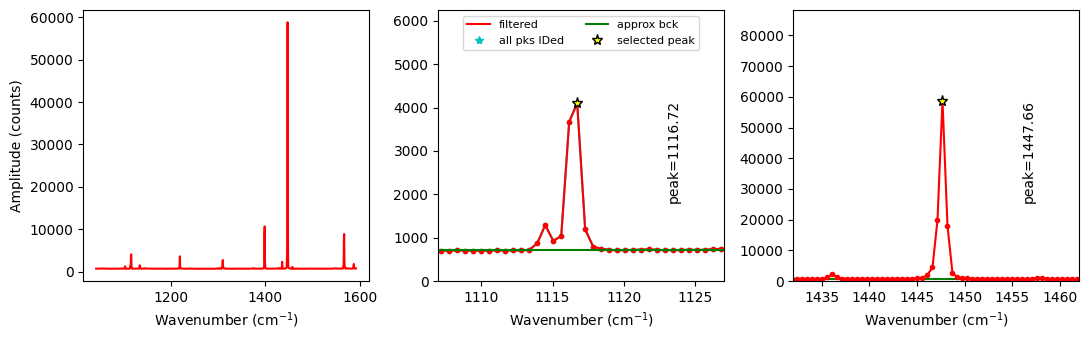

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=spectra_filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, peaks_2=1, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), LH_offset_mini2=None, x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  \
0  Ne--Spectrum--002--Spec.Data 1.txt         0.000032    0.000032   

   pk2_peak_cent  pk2_amplitude  pk2_sigma pk2_gamma  error_pk2  \
0    1447.647797    56114.63765    0.39389      None   0.001961   

   Peak2_Prop_Lor  pk1_peak_cent  ...  Peak1_Prop_Lor     deltaNe  Ne_Corr  \
0        0.407028    1116.477966  ...        0.208033  331.169831  0.99791   

   Ne_Corr_min  Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  \
0     0.997872     0.997947    148.314392     12.199009        160.513401   

   error_pk1_amplitude  error_pk2_amplitude  
0           235.225597           372.981379  

[1 rows x 24 columns]

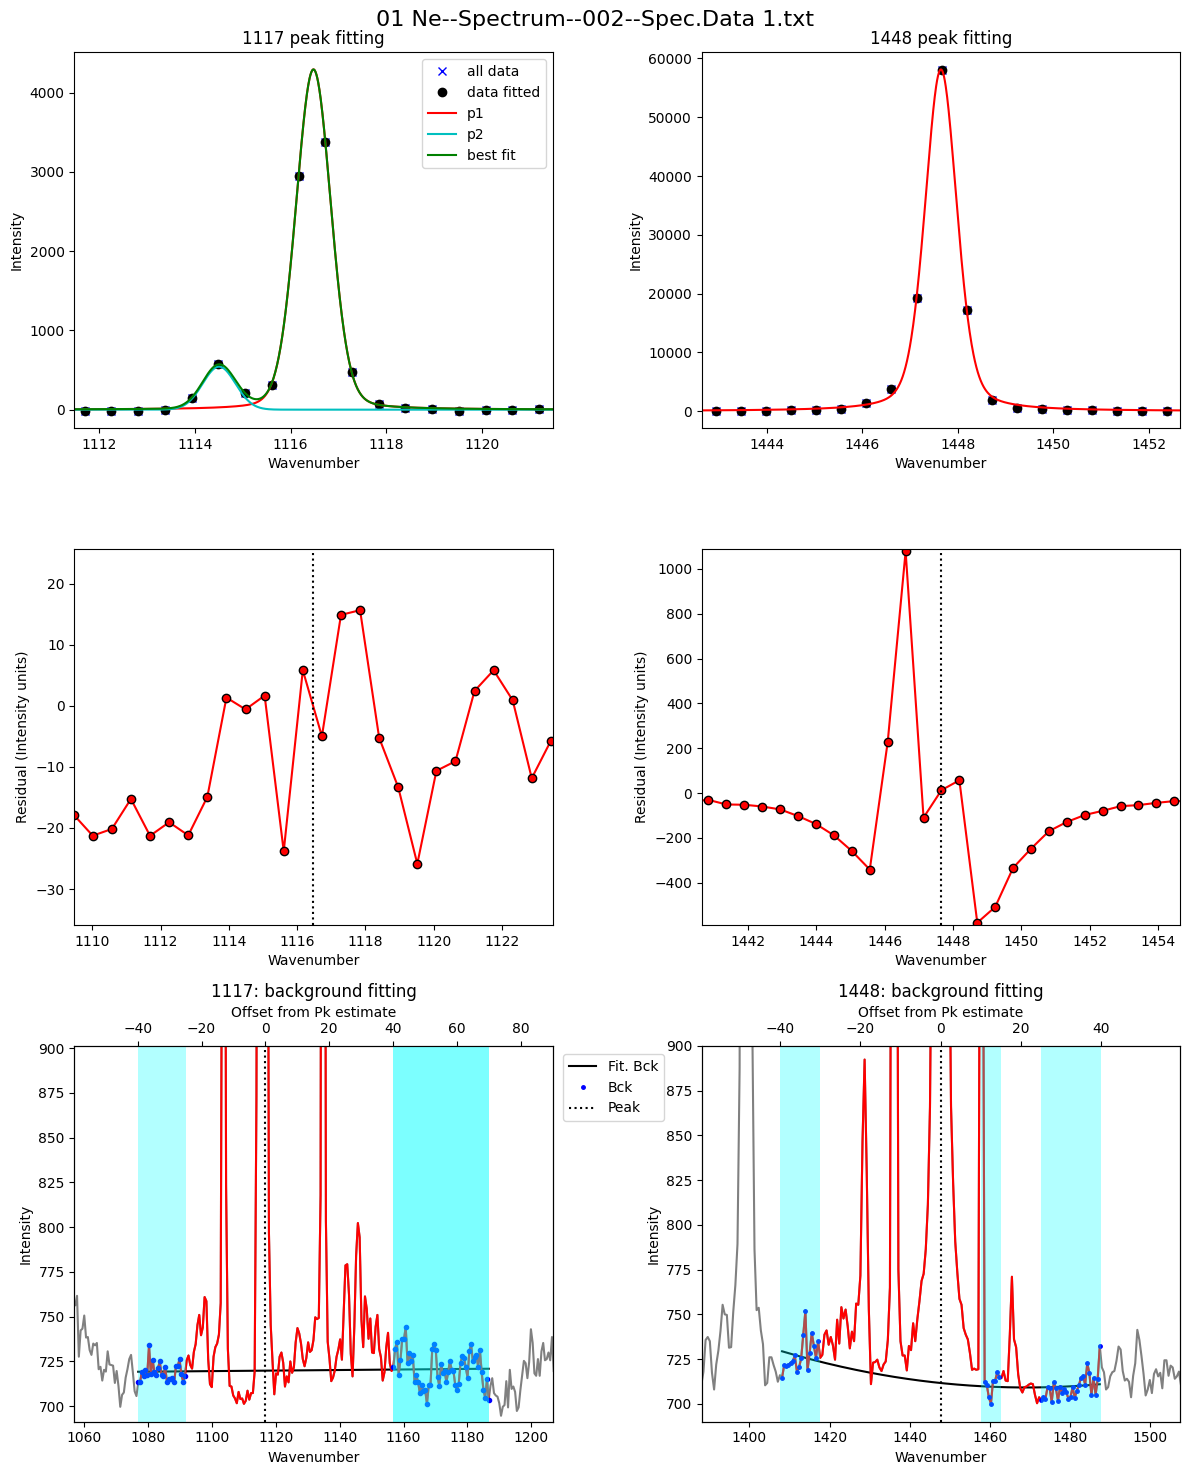

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/17 [00:00<?, ?it/s]

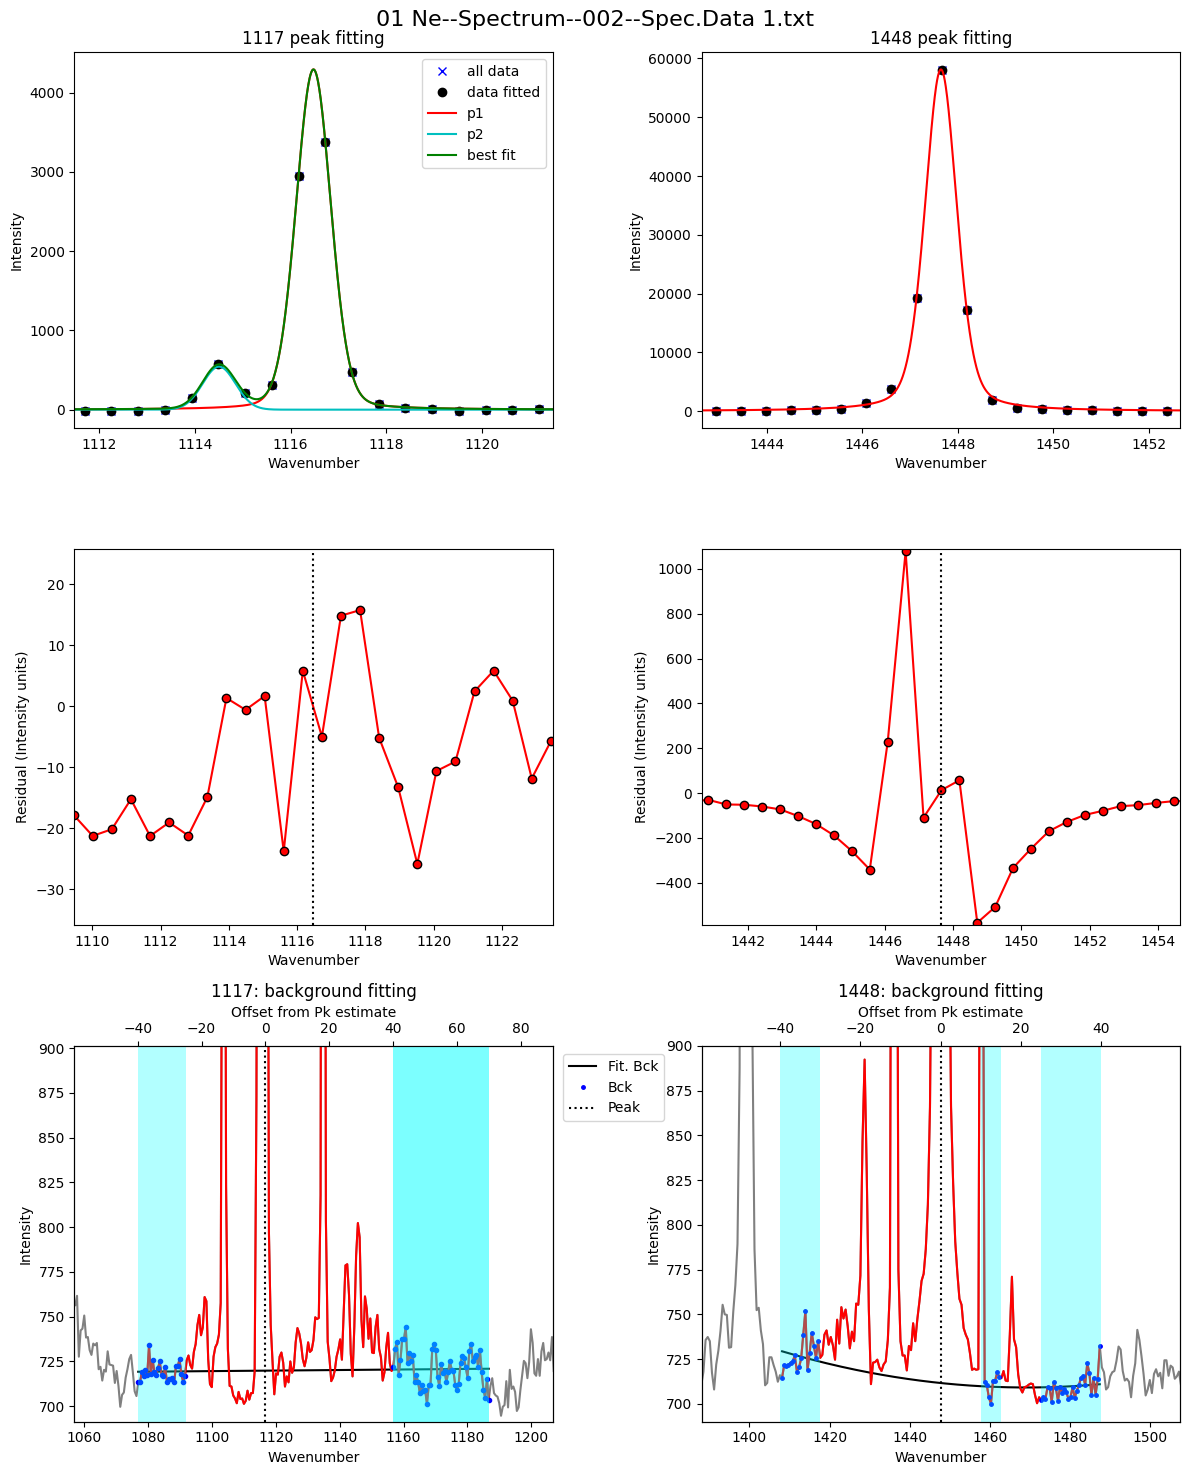

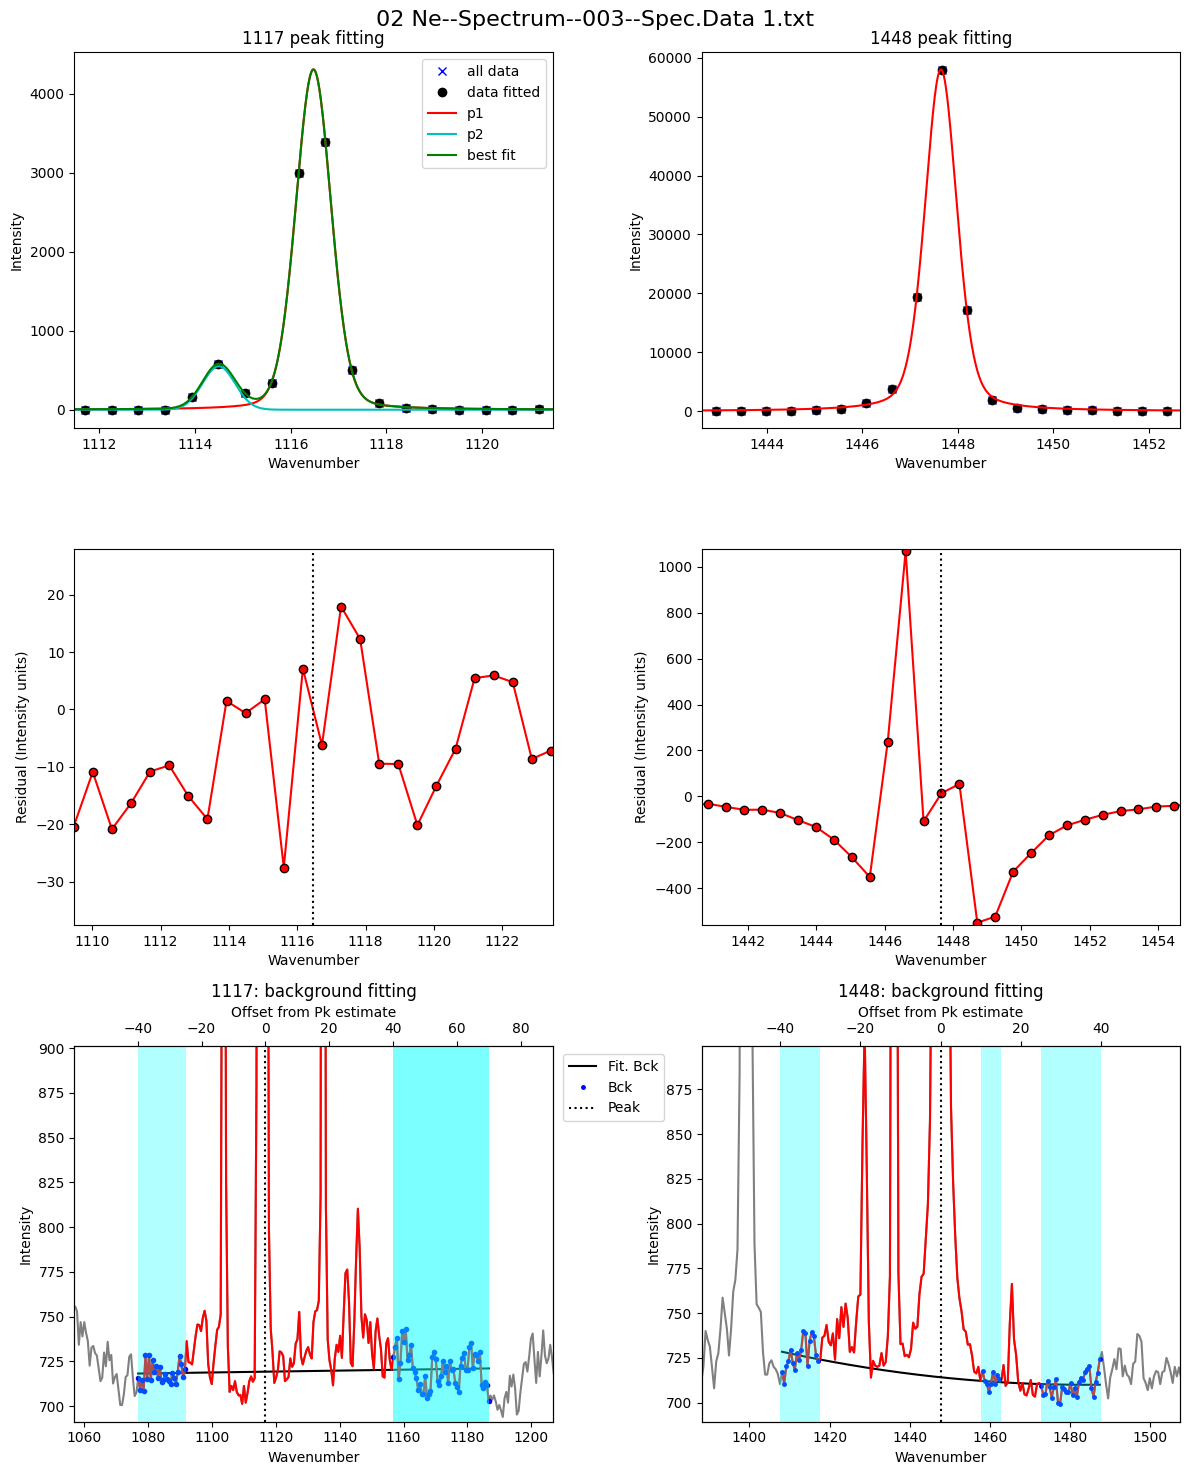

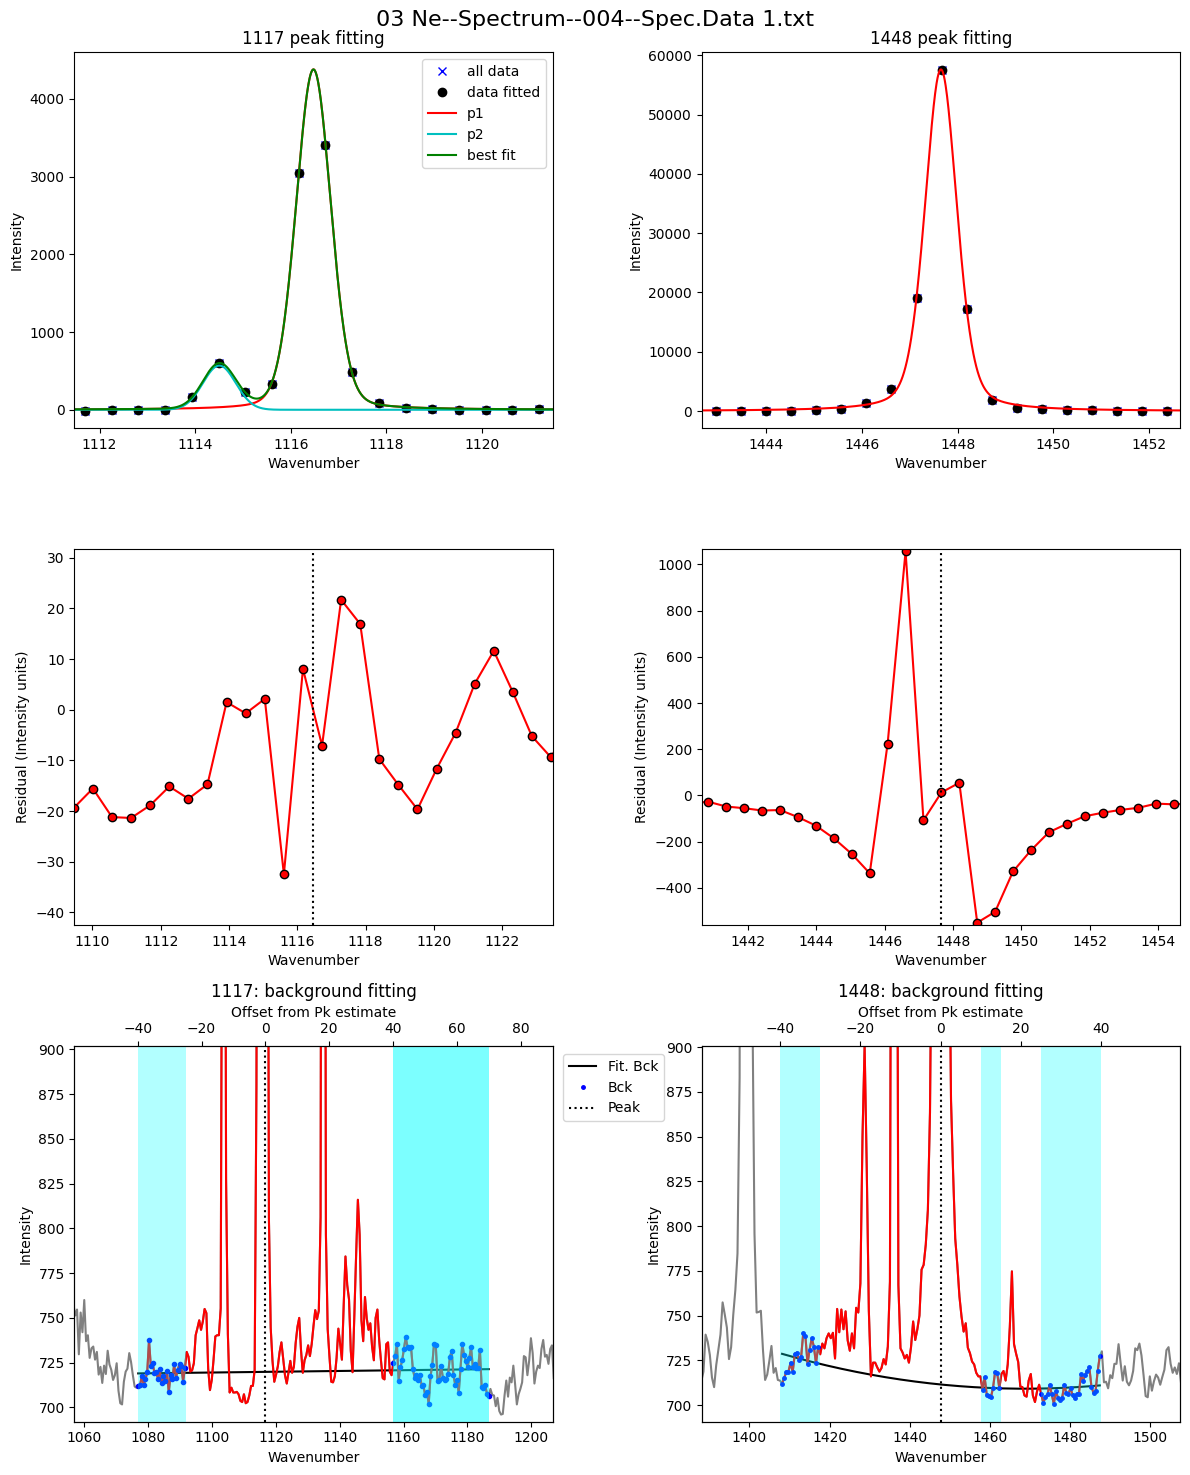

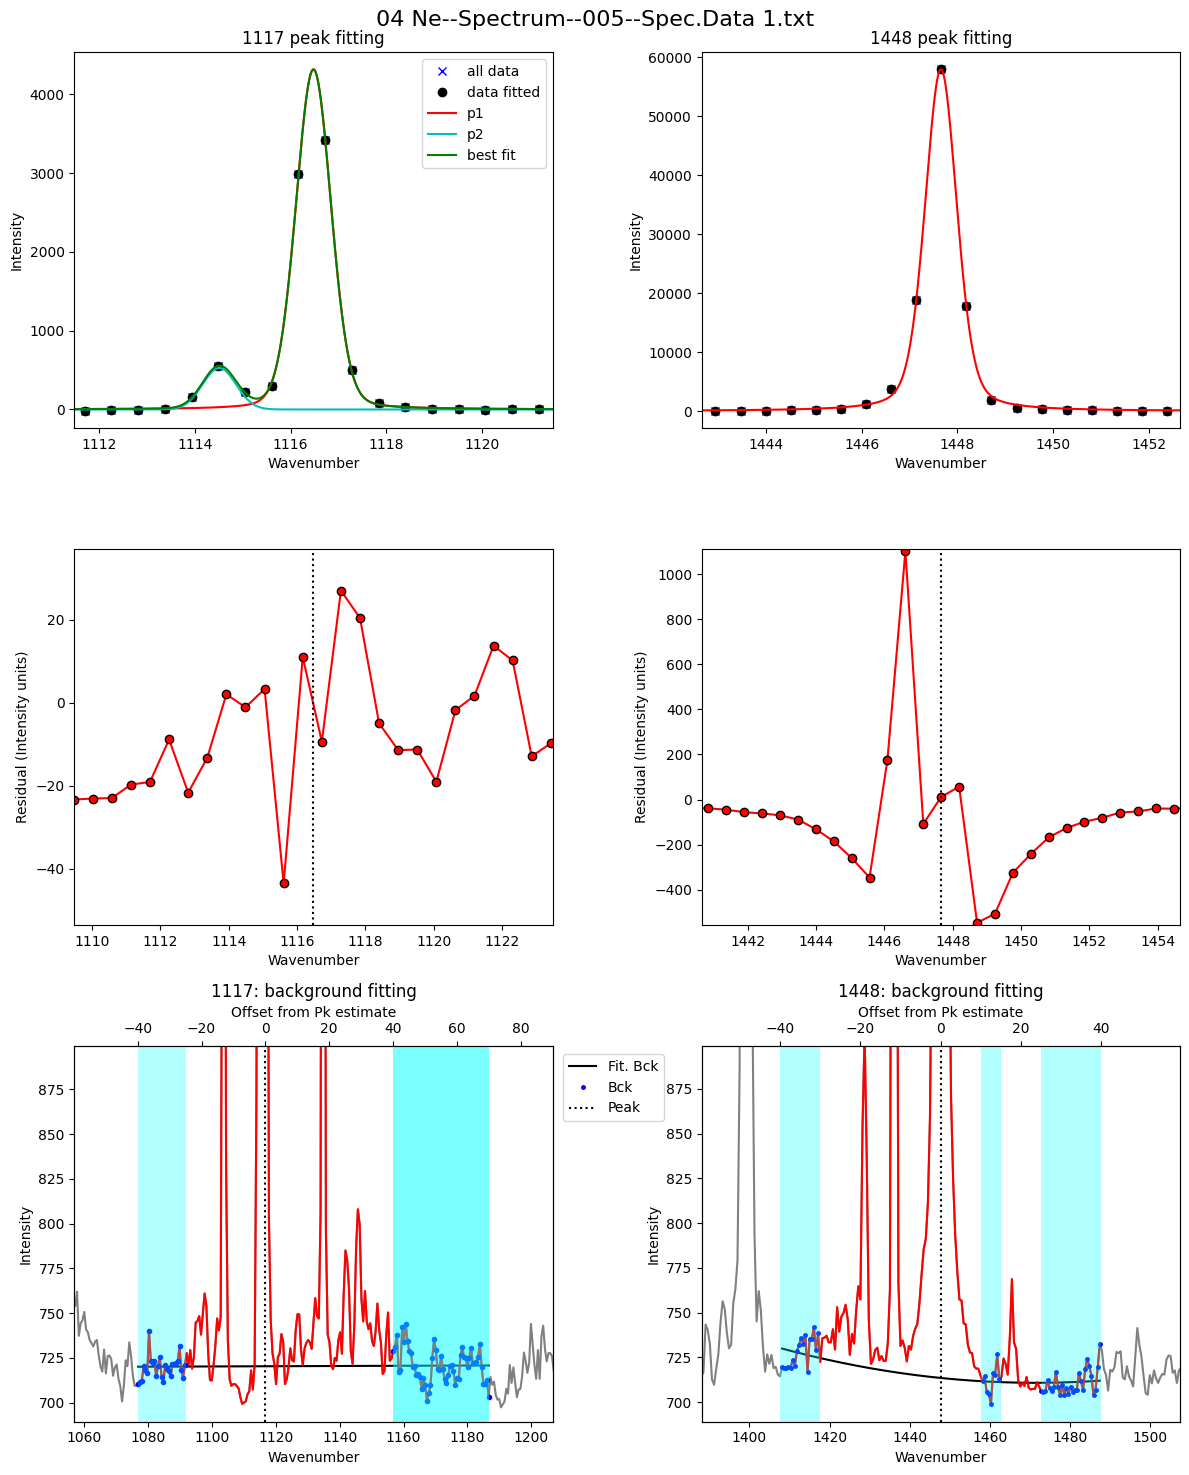

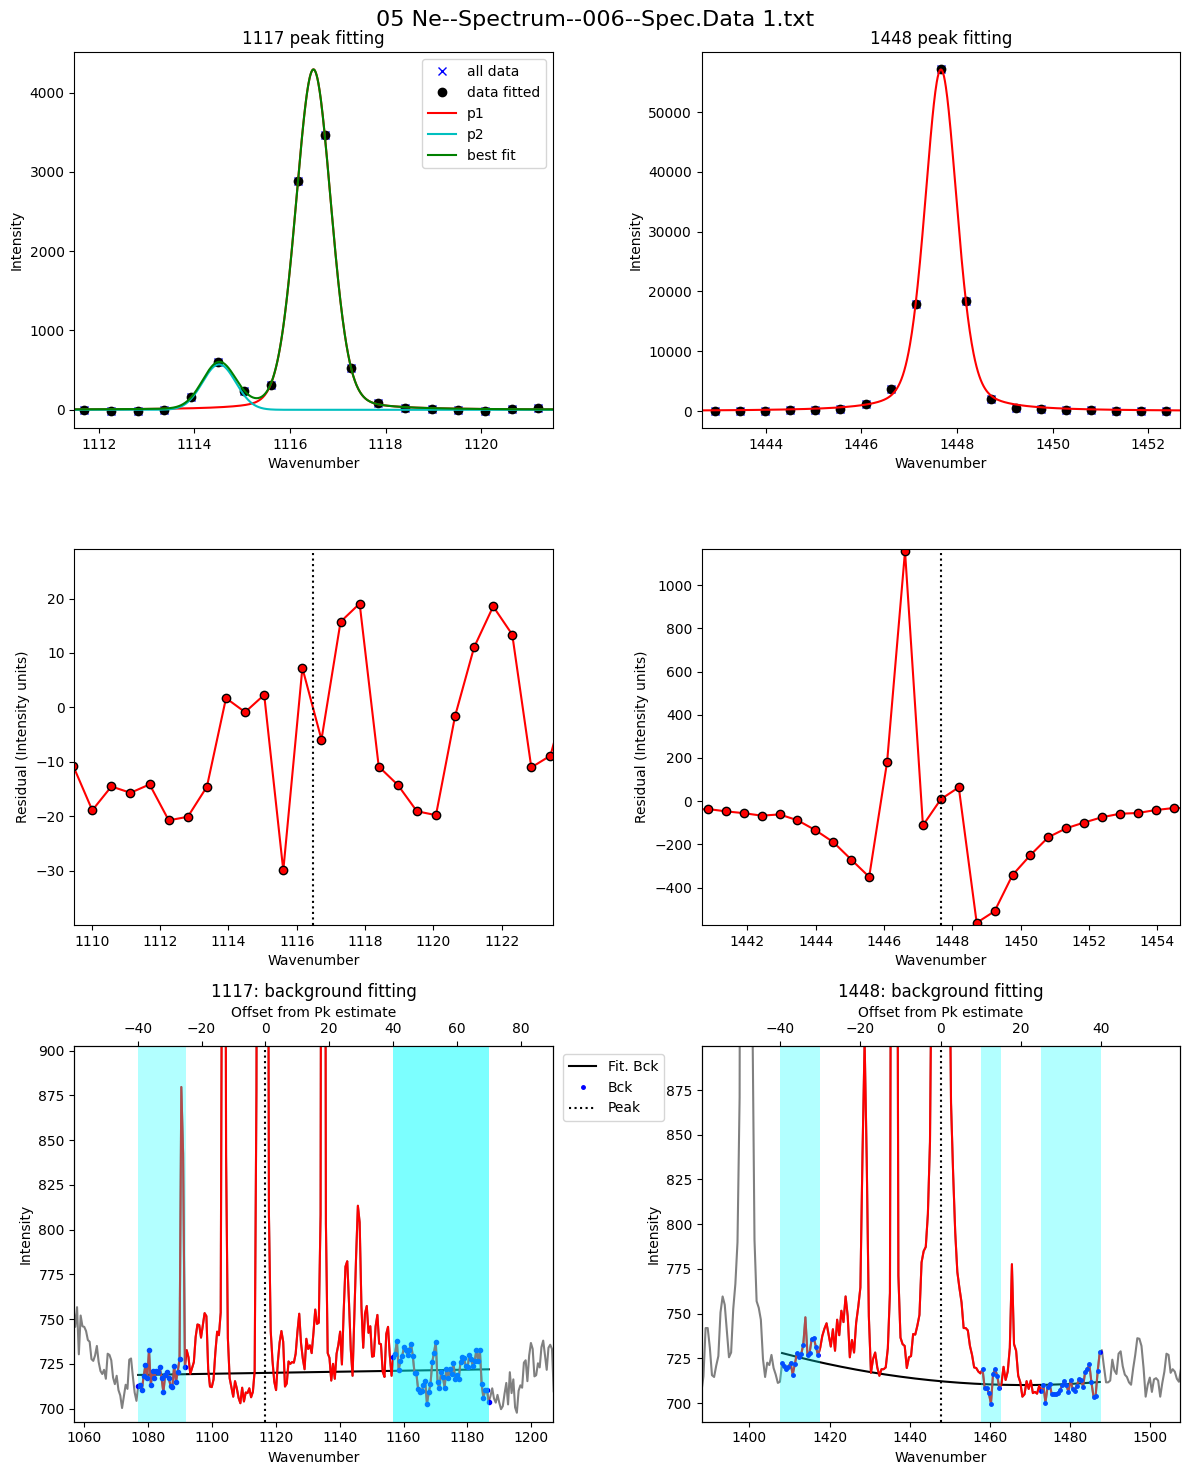

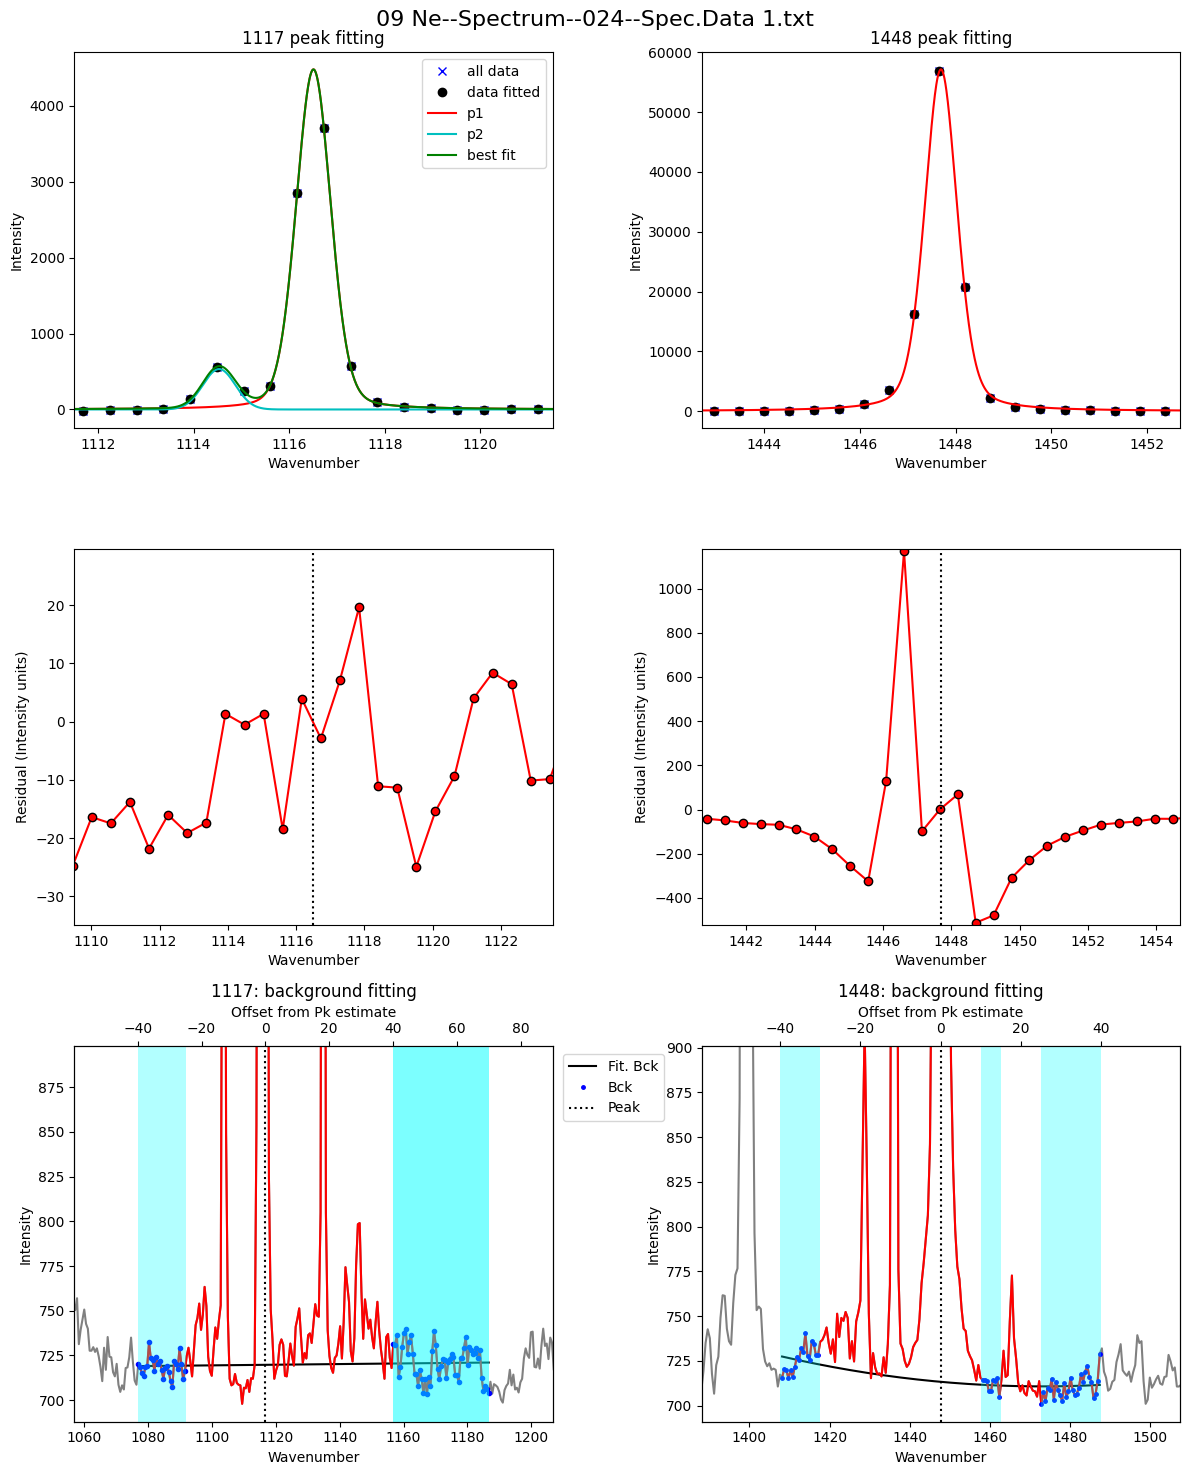

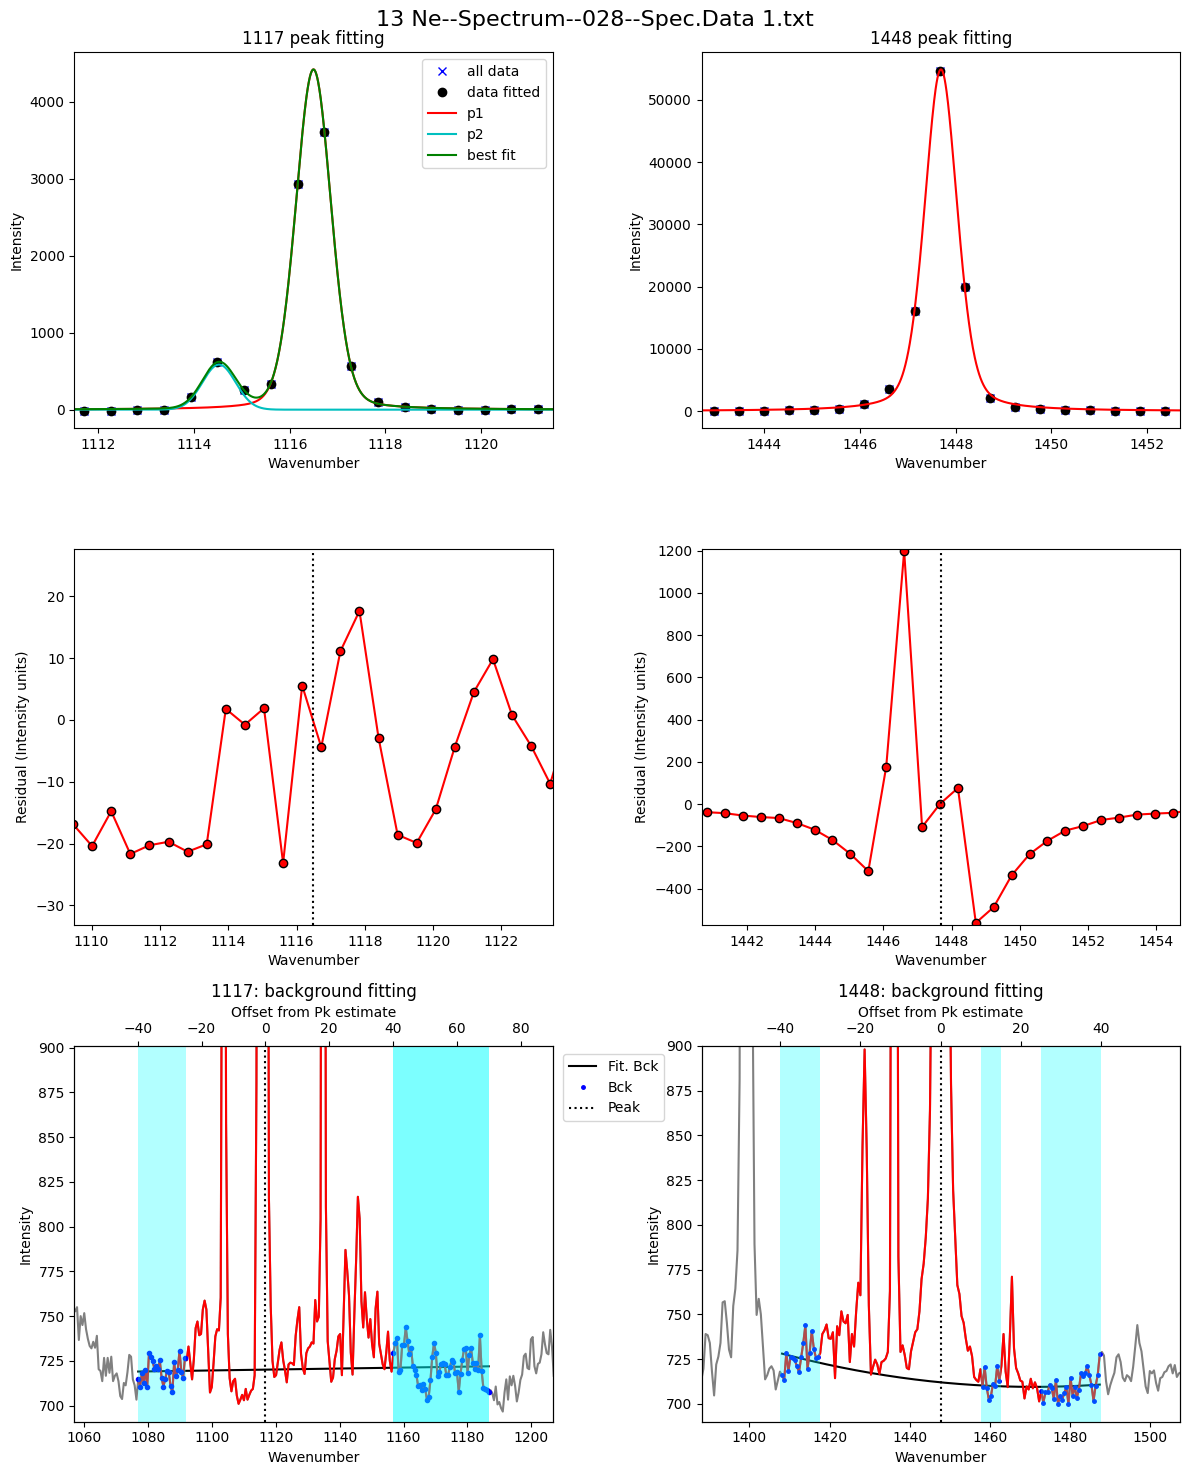

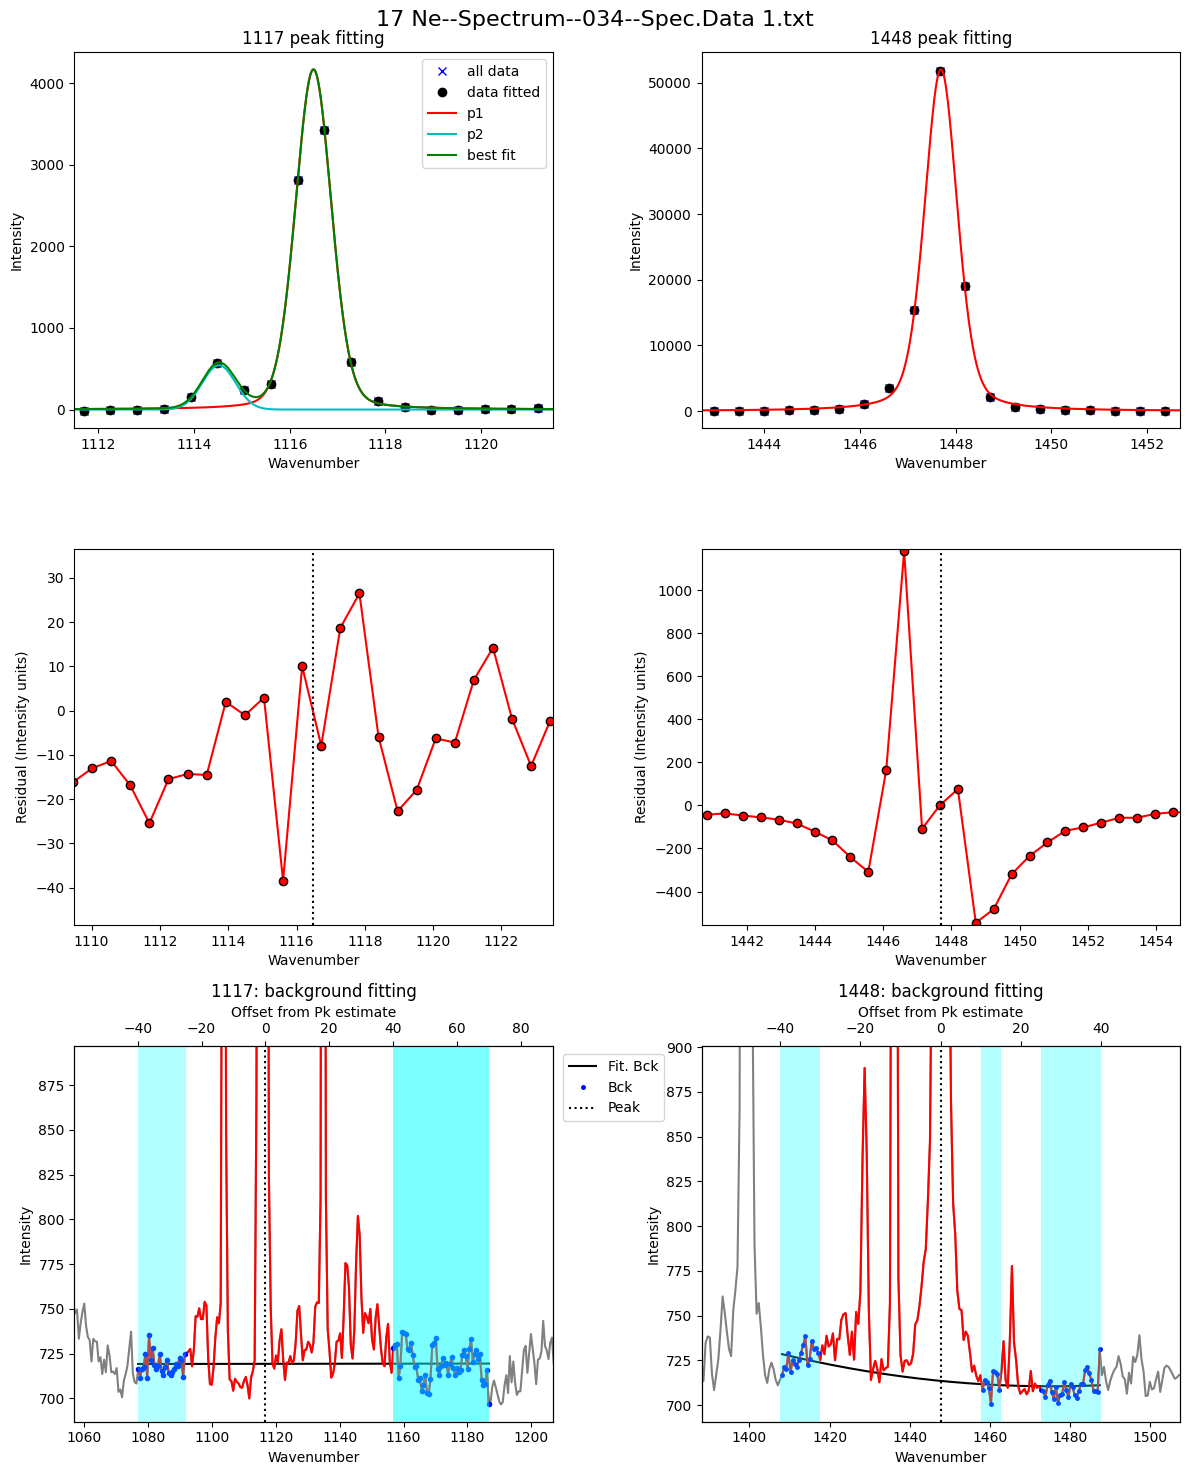

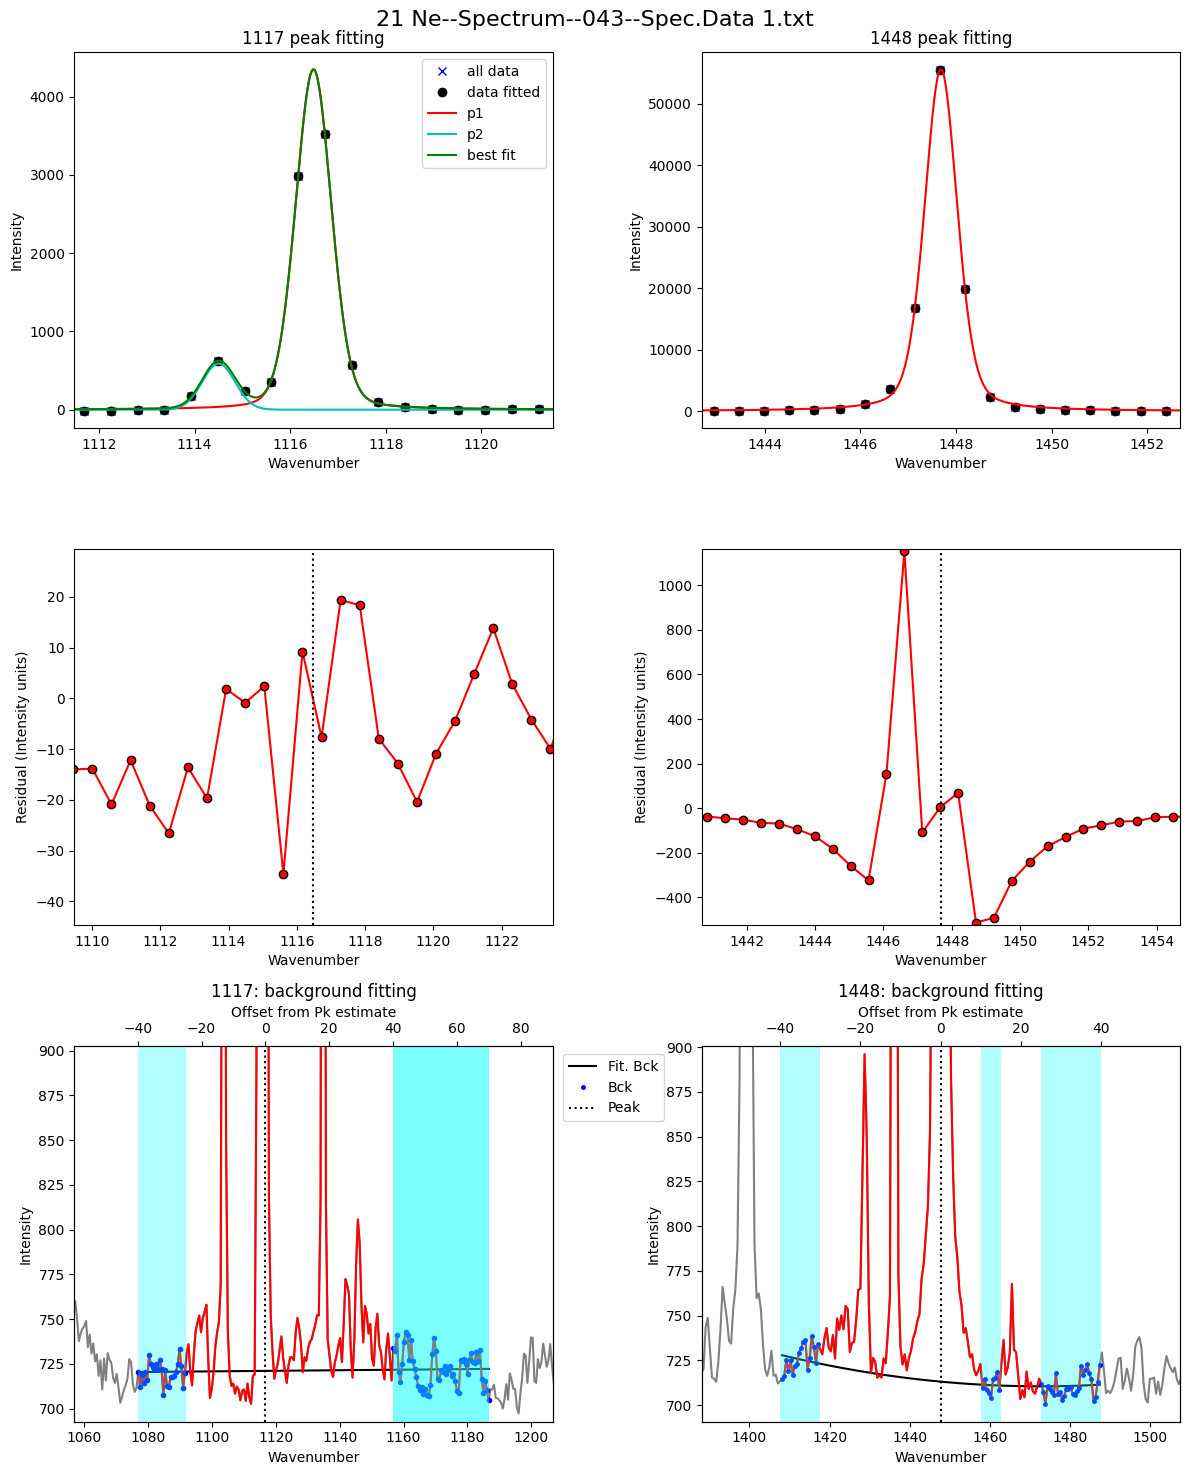

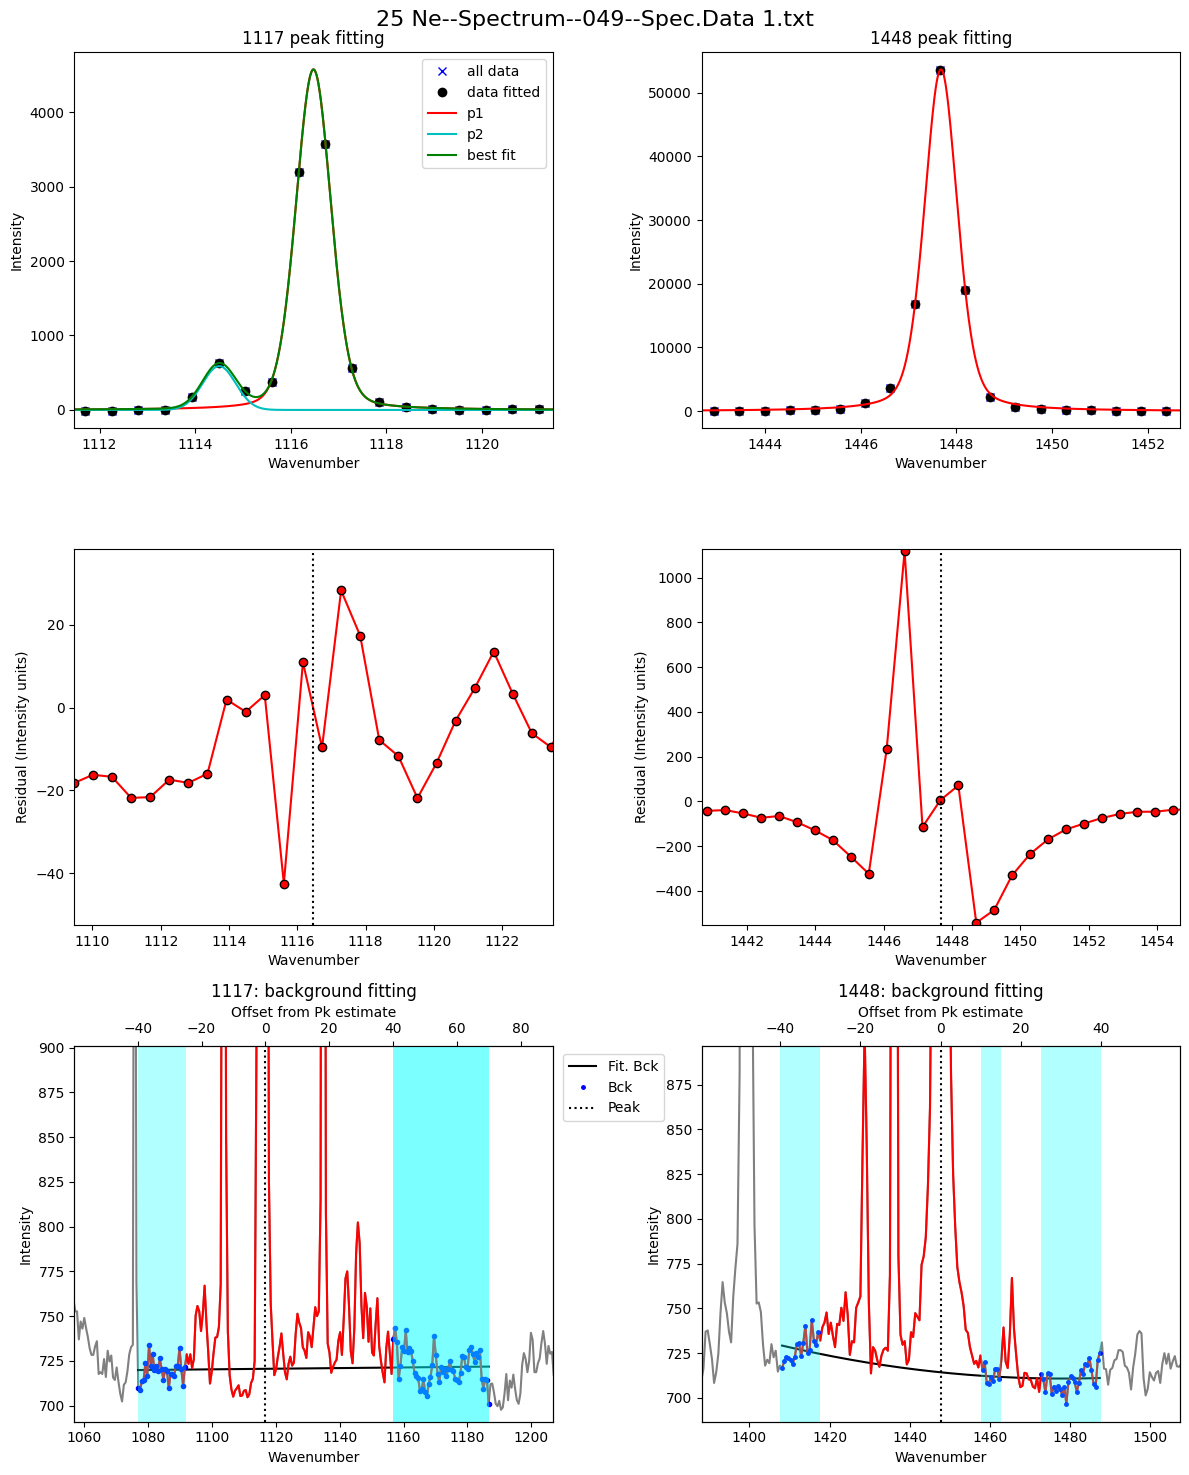

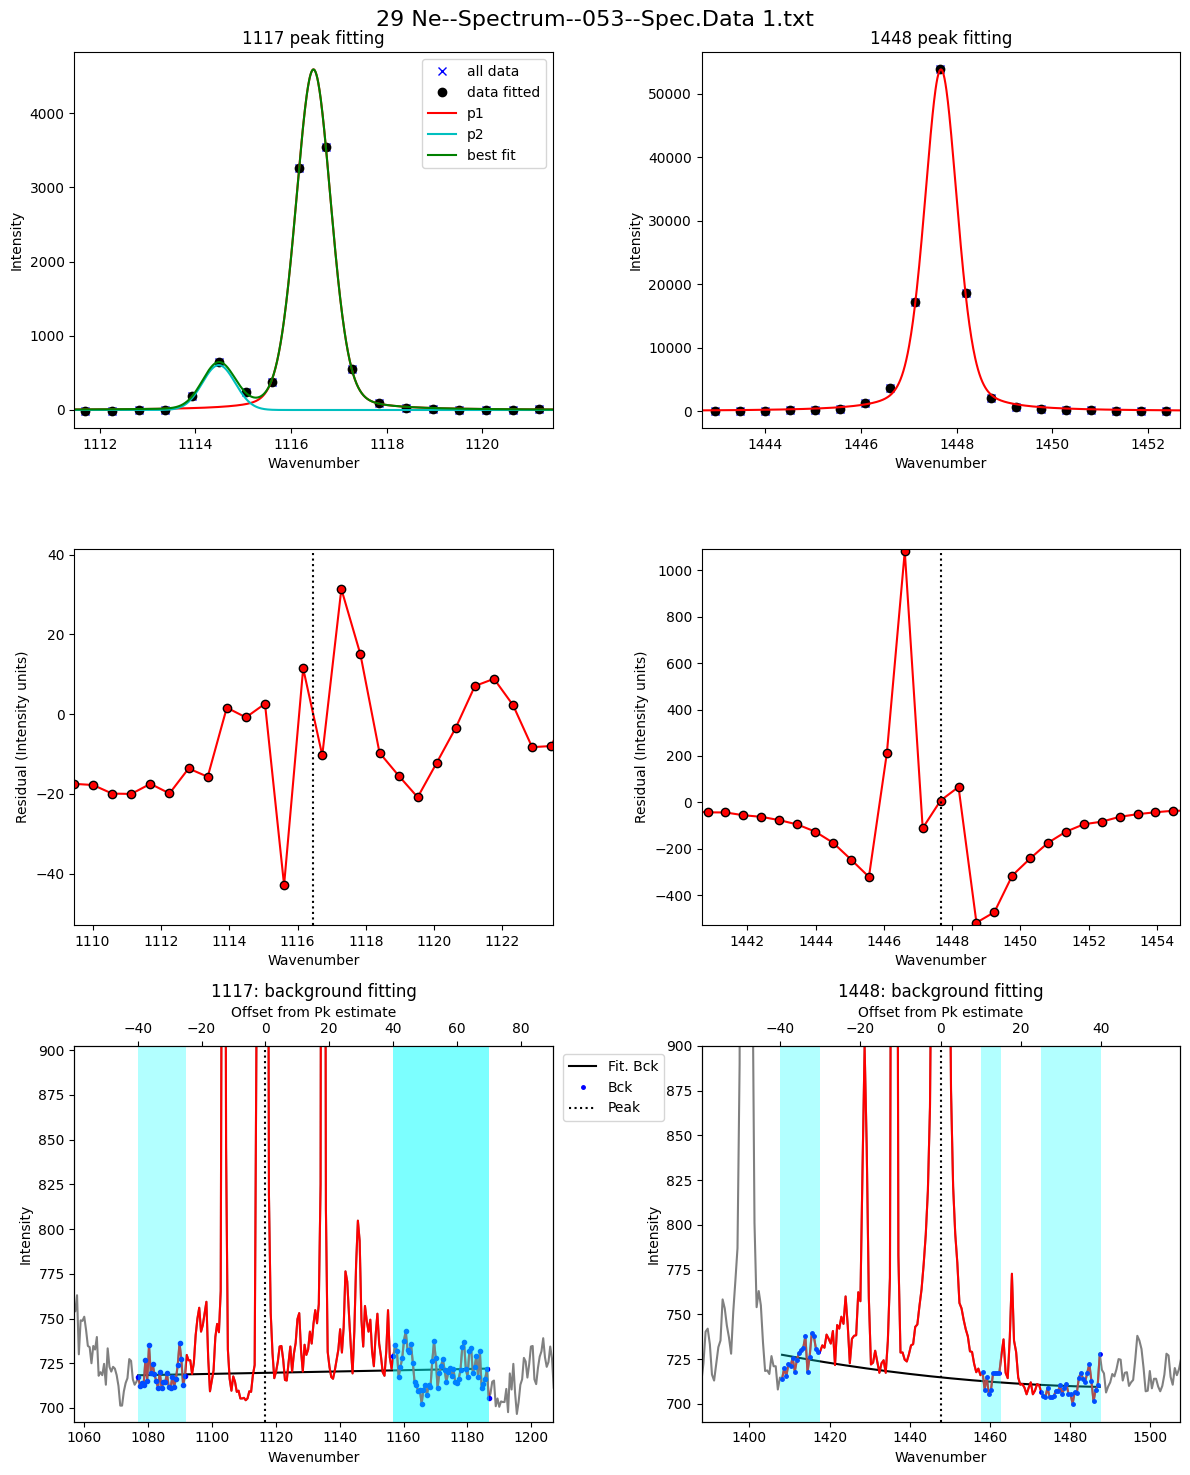

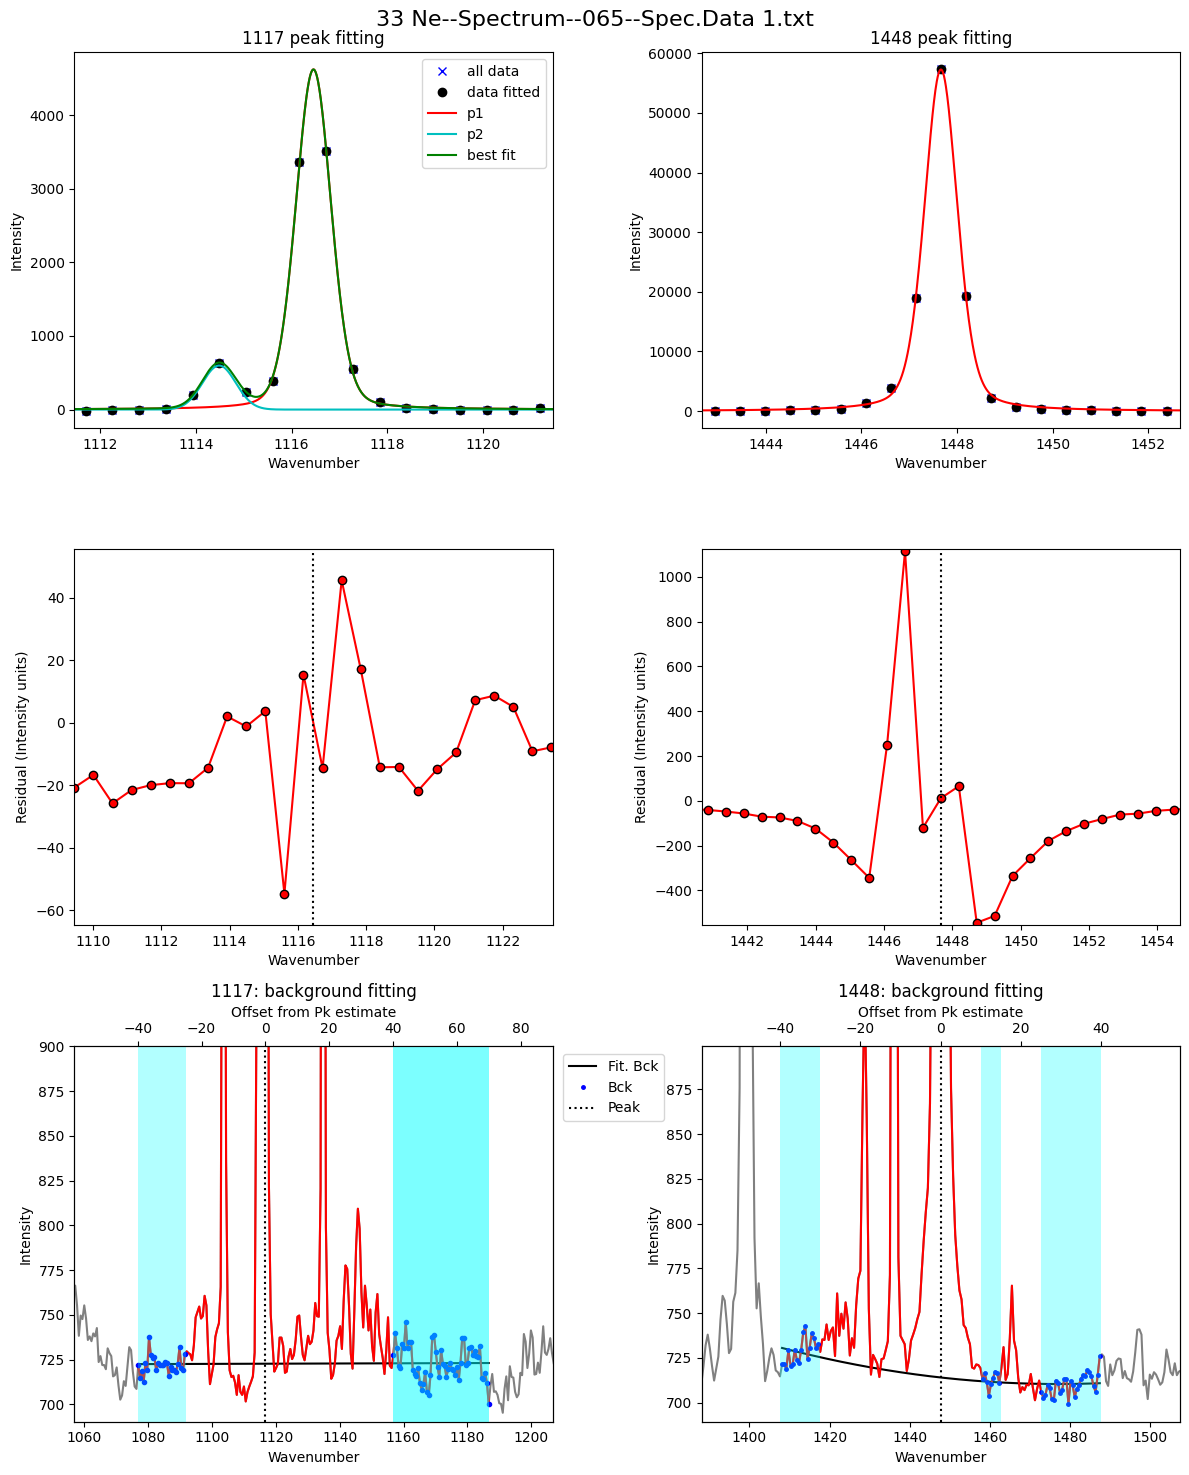

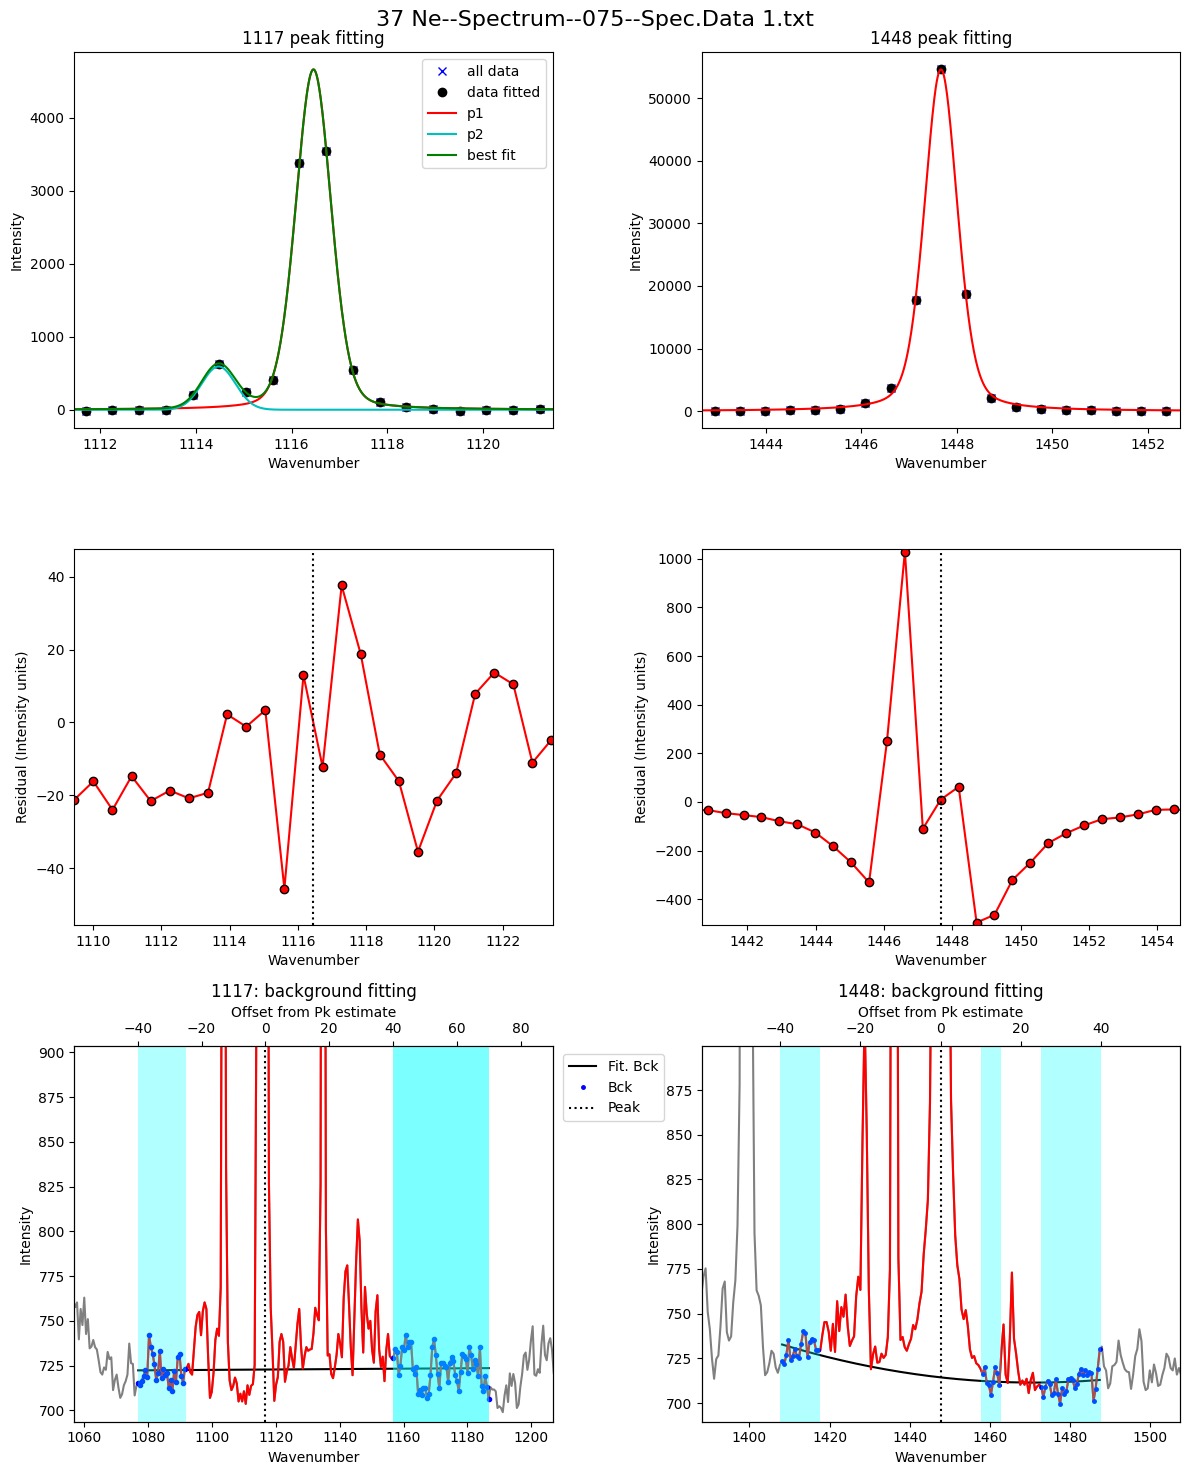

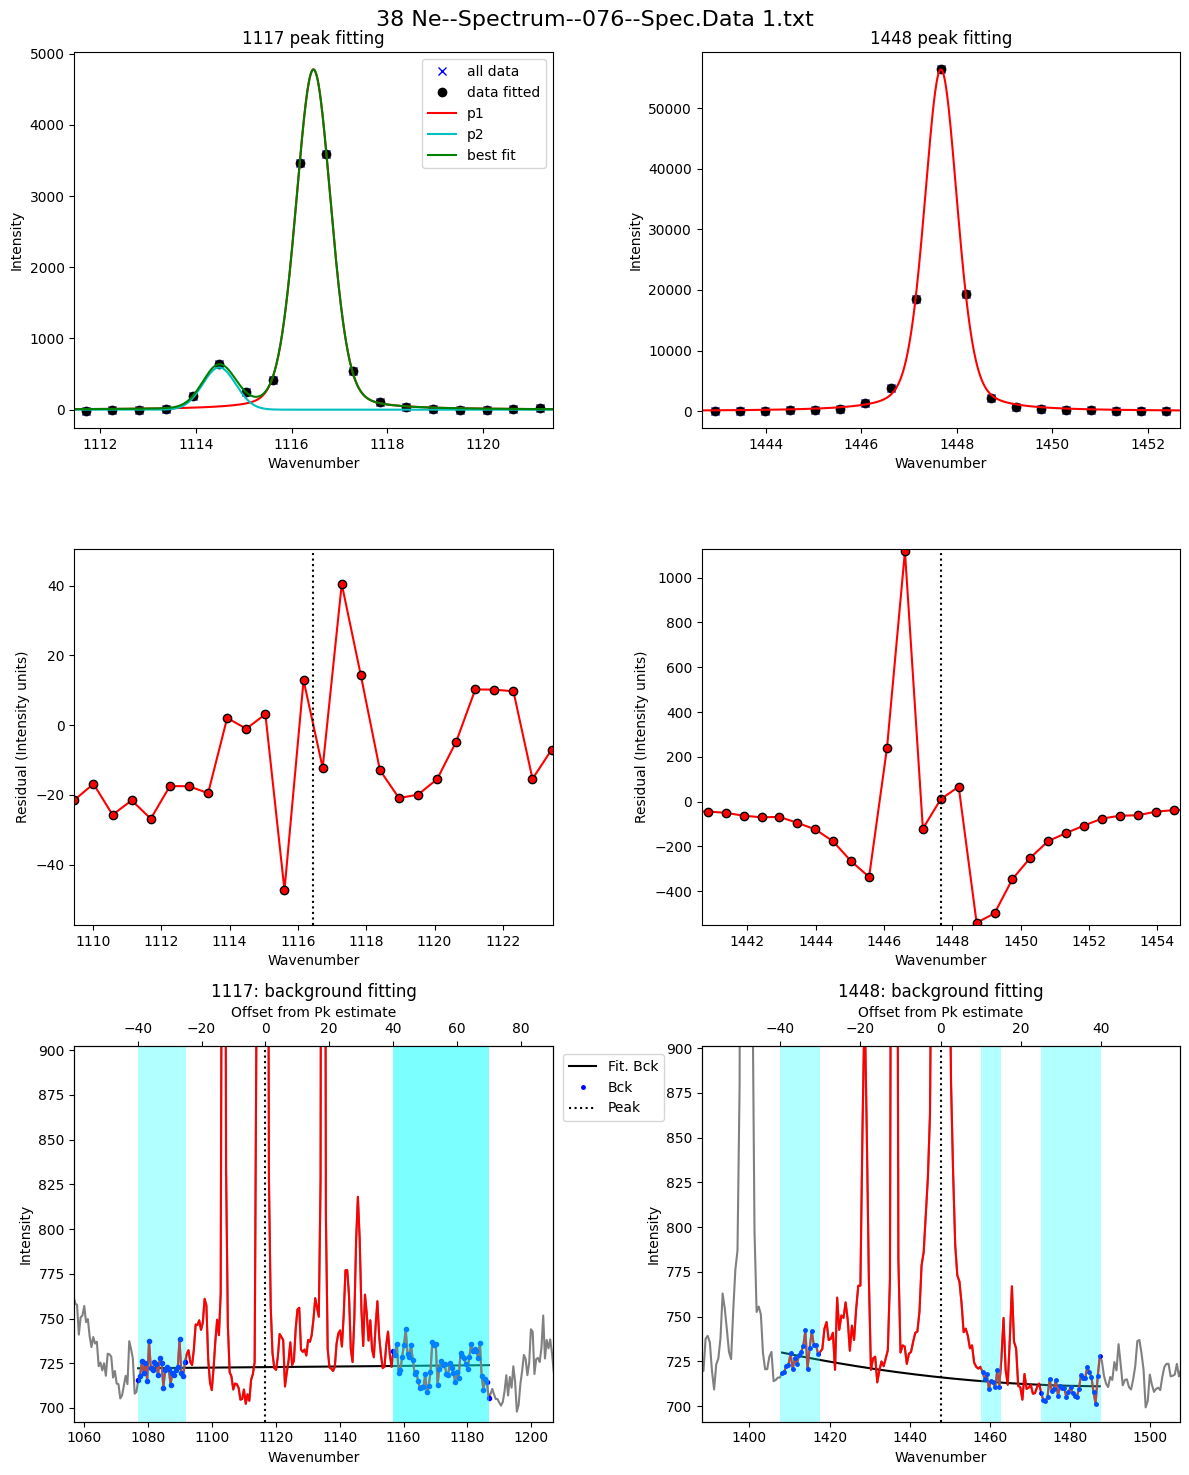

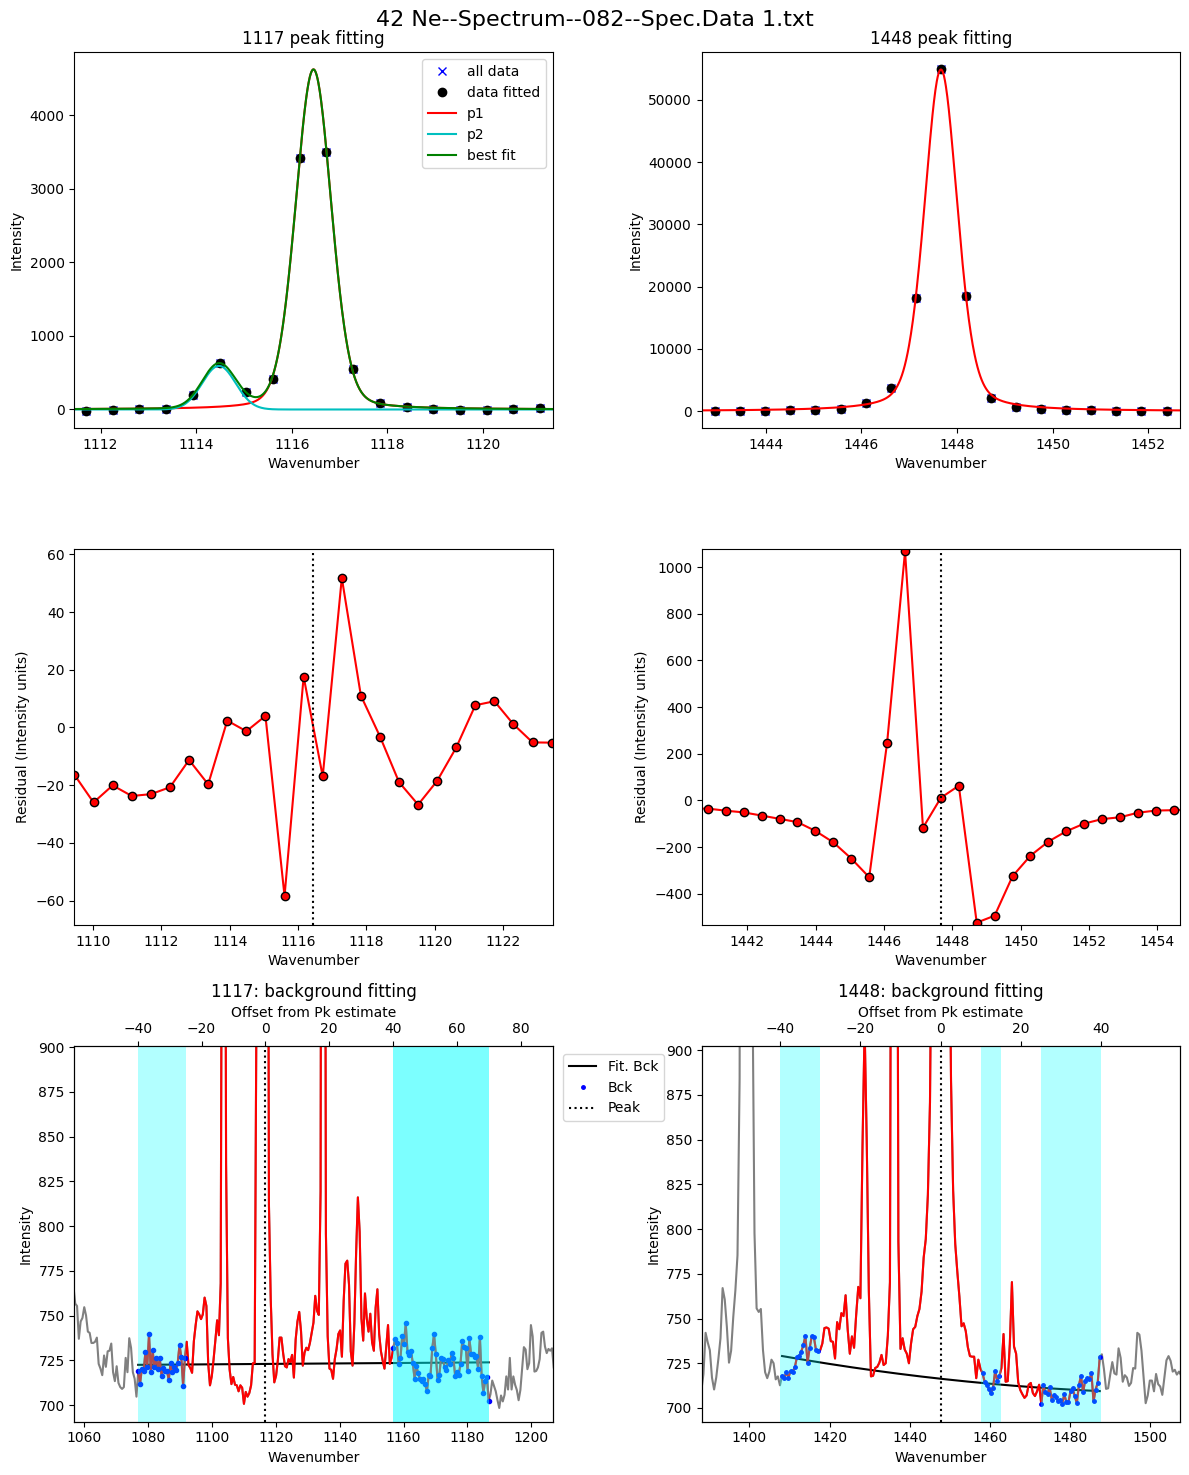

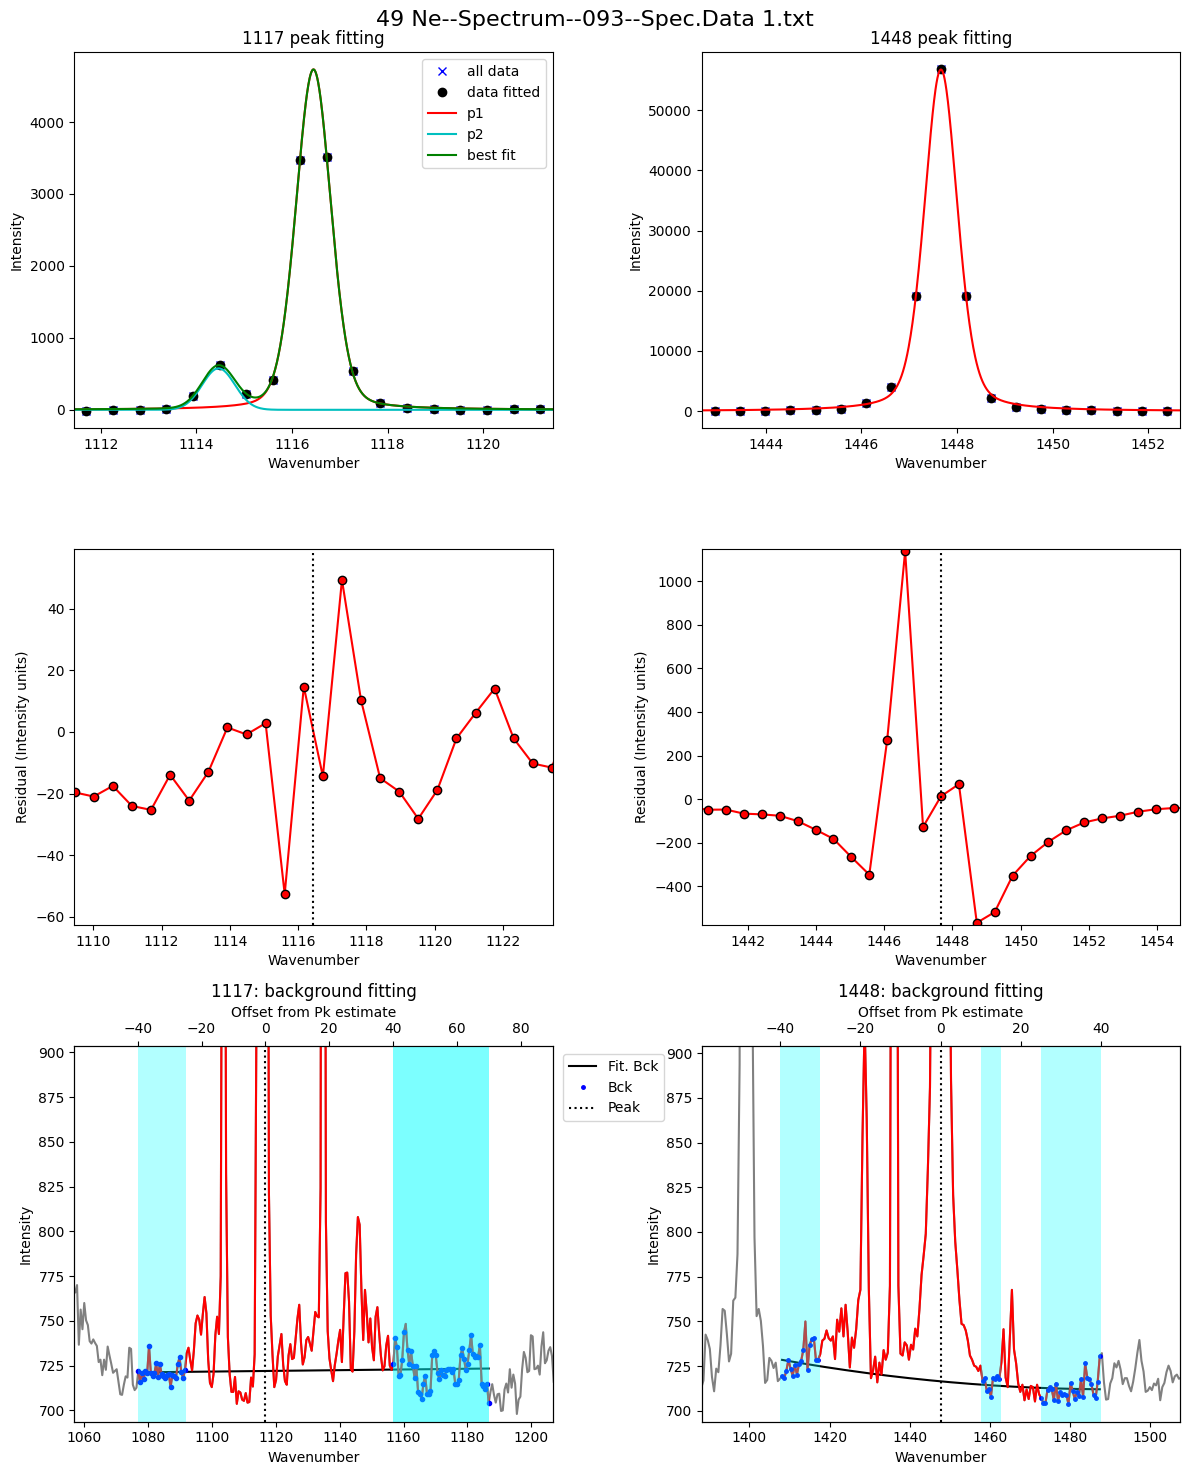

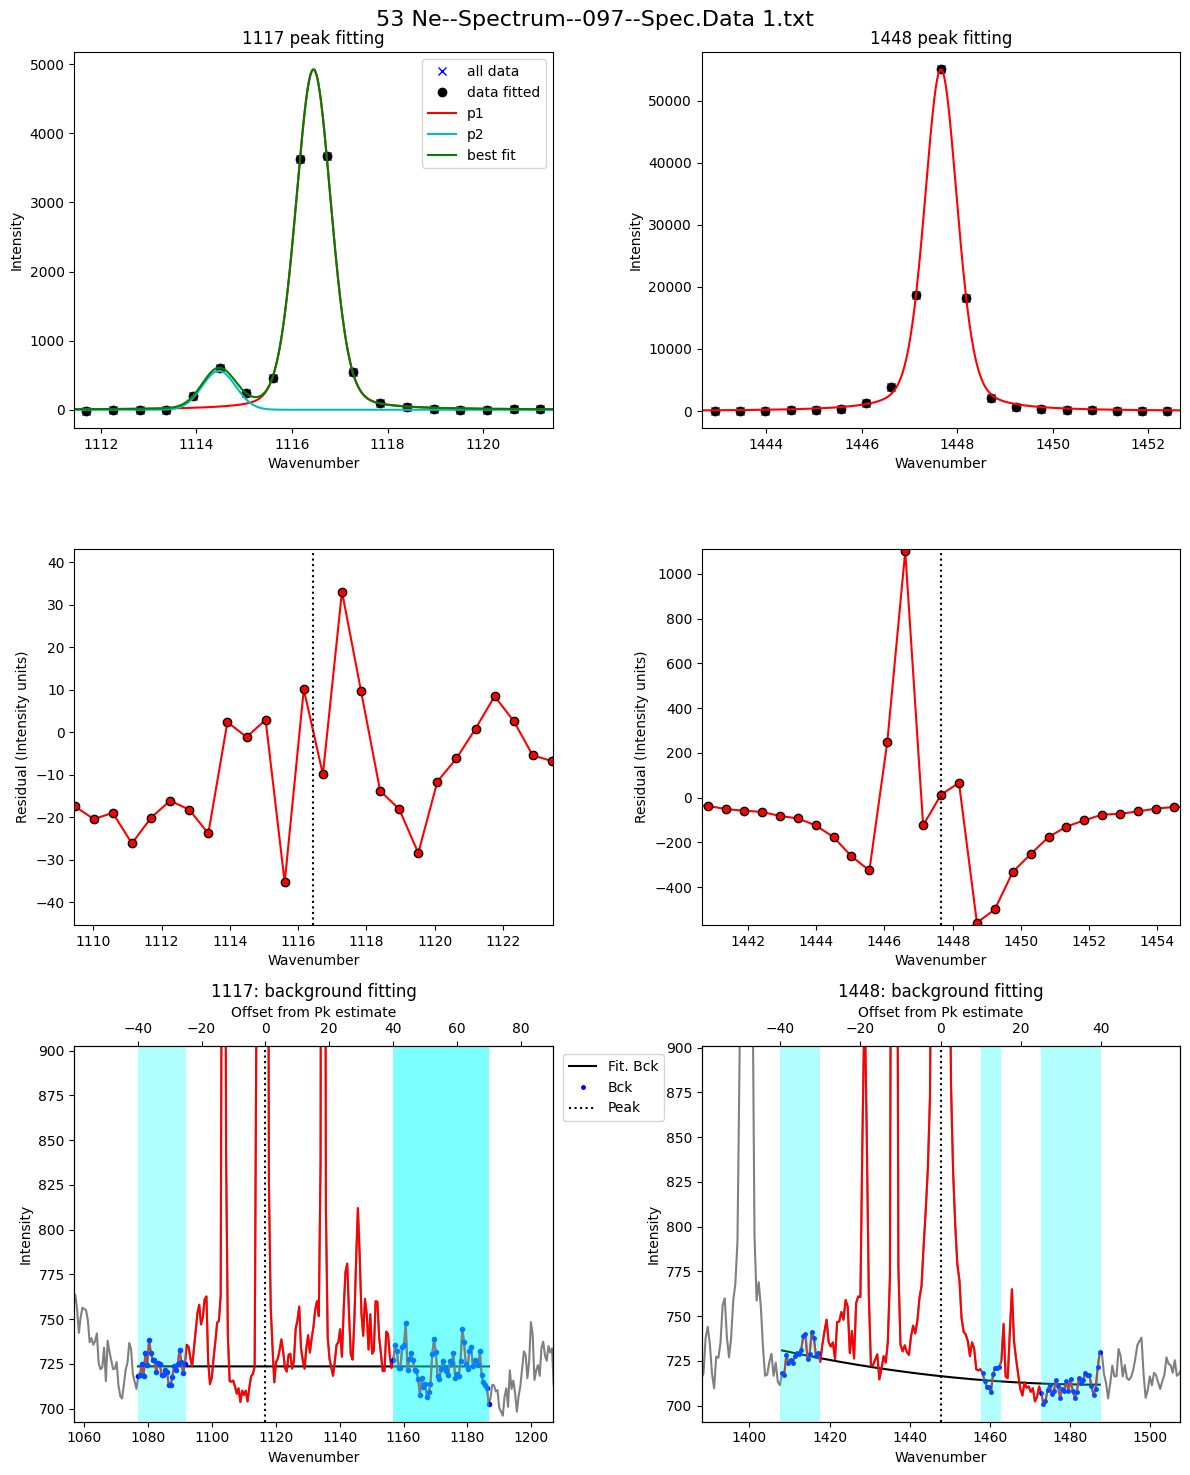

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=spectra_filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [14]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  \
0   Ne--Spectrum--002--Spec.Data 1.txt  0.997910    0.000032  331.169823   
1   Ne--Spectrum--003--Spec.Data 1.txt  0.997906    0.000031  331.171226   
2   Ne--Spectrum--004--Spec.Data 1.txt  0.997891    0.000030  331.176045   
3   Ne--Spectrum--005--Spec.Data 1.txt  0.997894    0.000031  331.175170   
4   Ne--Spectrum--006--Spec.Data 1.txt  0.997895    0.000034  331.174886   
5   Ne--Spectrum--024--Spec.Data 1.txt  0.997859    0.000034  331.186546   
6   Ne--Spectrum--028--Spec.Data 1.txt  0.997837    0.000033  331.194024   
7   Ne--Spectrum--034--Spec.Data 1.txt  0.997836    0.000036  331.194412   
8   Ne--Spectrum--043--Spec.Data 1.txt  0.997828    0.000035  331.196887   
9   Ne--Spectrum--049--Spec.Data 1.txt  0.997807    0.000031  331.203841   
10  Ne--Spectrum--053--Spec.Data 1.txt  0.997803    0.000029  331.205154   
11  Ne--Spectrum--065--Spec.Data 1.txt  0.997799    0.000027  331.206631   
12  Ne--Spectrum--075--Spec.Data 1.txt  0.997789    0.000026  331.209919   
13  Ne--Spectrum--076--Spec.Data 1.txt  0.997783    0.000026  331.211884   
14  Ne--Spectrum--082--Spec.Data 1.txt  0.997787    0.000026  331.210491   
15  Ne--Spectrum--093--Spec.Data 1.txt  0.997781    0.000027  331.212465   
16  Ne--Spectrum--097--Spec.Data 1.txt  0.997789    0.000026  331.209959   

    pk2_peak_cent  pk1_peak_cent  pk2_amplitude  pk1_amplitude  residual_pk2  \
0     1447.647797    1116.477975   56114.640255    4198.357292    148.314486   
1     1447.647155    1116.475929   56007.833251    4283.368296    140.018211   
2     1447.649415    1116.473370   55677.622399    4310.456149    135.399234   
3     1447.654778    1116.479608   55962.718075    4250.855446    137.327805   
4     1447.665471    1116.490584   55561.603535    4265.108471    139.673117   
5     1447.693979    1116.507434   55636.943766    4442.747277    134.227190   
6     1447.690325    1116.496301   54017.498415    4428.082016    138.236551   
7     1447.691364    1116.496952   51488.432967    4252.592500    135.555752   
8     1447.684261    1116.487374   54860.586031    4426.853678    136.147303   
9     1447.677814    1116.473973   53415.099753    4620.933133    137.364262   
10    1447.672562    1116.467408   53464.021836    4631.693424    135.662254   
11    1447.664702    1116.458071   56912.361563    4666.619298    142.503463   
12    1447.668563    1116.458644   54413.594809    4729.567637    133.277319   
13    1447.667741    1116.455858   56221.647395    4818.782392    141.985748   
14    1447.664412    1116.453921   54676.236205    4695.956654    137.421725   
15    1447.661952    1116.449486   56828.288024    4770.791867    147.640371   
16    1447.659310    1116.449351   55008.288882    4981.019262    141.396988   

    residual_pk1  ...  Peak2_Prop_Lor  pk1_sigma pk1_gamma  error_pk1  \
0      12.192540  ...        0.407028   0.428559      None   0.010495   
1      10.913952  ...        0.402722   0.433668      None   0.010251   
2      12.337922  ...        0.402411   0.428572      None   0.009749   
3      13.598225  ...        0.402209   0.432389      None   0.010084   
4      12.418551  ...        0.404848   0.433158      None   0.010991   
5      11.541313  ...        0.395864   0.426693      None   0.011194   
6      11.733171  ...        0.402652   0.434235      None   0.010900   
7      12.092650  ...        0.406444   0.442405      None   0.011820   
8      12.192469  ...        0.403550   0.441149      None   0.011424   
9      13.045312  ...        0.405685   0.433057      None   0.010037   
10     13.020857  ...        0.408779   0.433687      None   0.009458   
11     15.334241  ...        0.399171   0.435083      None   0.008706   
12     15.565240  ...        0.403260   0.436137      None   0.008225   
13     15.521044  ...        0.400023   0.430745      None   0.008508   
14     15.247939  ...        0.400571   0.440044      None   0.008516   
15     15.718406  ...        0.410139   0.430800    

## Now extract metadata to get a timestamp for each file

In [15]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['03 Ne--Spectrum--002--Information.txt',
 '04 Ne--Spectrum--003--Information.txt',
 '05 Ne--Spectrum--004--Information.txt',
 '06 Ne--Spectrum--005--Information.txt',
 '07 Ne--Spectrum--006--Information.txt']

In [16]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 17/17 [00:10<00:00,  1.56it/s]

Done


filename                date    Month   Day  \
0  Ne--Spectrum--002--Information.txt  January 10, 2024\n  January  10.0   
1  Ne--Spectrum--003--Information.txt  January 10, 2024\n  January  10.0   
2  Ne--Spectrum--004--Information.txt  January 10, 2024\n  January  10.0   
3  Ne--Spectrum--005--Information.txt  January 10, 2024\n  January  10.0   
4  Ne--Spectrum--006--Information.txt  January 10, 2024\n  January  10.0   

   power (mW)  Int_time (s)  accumulations  Mag (X)             duration  \
0       9.957          45.0            3.0      5.0  ['0h', '2m', '16s']   
1       9.910          45.0            3.0      5.0  ['0h', '2m', '16s']   
2       9.852          45.0            3.0      5.0  ['0h', '2m', '16s']   
3       9.814          45.0            3.0      5.0  ['0h', '2m', '16s']   
4       9.877          45.0            3.0      5.0  ['0h', '2m', '16s']   

       24hr_time  sec since midnight  Spectral Center  
0  11:25:41 AM\n             41141.0         1325.004  
1  11:29:11 AM\n             41351.0         1325.004  
2  11:32:48 AM\n             41568.0         1325.004  
3  11:36:41 AM\n             41801.0         1325.004  
4  11:46:45 AM\n             42405.0         1325.004

In [17]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext=meta_file_ext)
file_m

for i in range(len(file_m)):
    file_m[i] = file_m[i].replace("--Information", "")
file_m


good job, no duplicate file names


array(['Ne--Spectrum--002', 'Ne--Spectrum--003', 'Ne--Spectrum--004',
       'Ne--Spectrum--005', 'Ne--Spectrum--006', 'Ne--Spectrum--024',
       'Ne--Spectrum--028', 'Ne--Spectrum--034', 'Ne--Spectrum--043',
       'Ne--Spectrum--049', 'Ne--Spectrum--053', 'Ne--Spectrum--065',
       'Ne--Spectrum--075', 'Ne--Spectrum--076', 'Ne--Spectrum--082',
       'Ne--Spectrum--093', 'Ne--Spectrum--097'], dtype=object)

In [18]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext=spectra_file_ext)
file_s

for i in range(len(file_s)):
    file_s[i] = file_s[i].replace("--Spec.Data 1", "")
file_s

good job, no duplicate file names


array(['Ne--Spectrum--002', 'Ne--Spectrum--003', 'Ne--Spectrum--004',
       'Ne--Spectrum--005', 'Ne--Spectrum--006', 'Ne--Spectrum--024',
       'Ne--Spectrum--028', 'Ne--Spectrum--034', 'Ne--Spectrum--043',
       'Ne--Spectrum--049', 'Ne--Spectrum--053', 'Ne--Spectrum--065',
       'Ne--Spectrum--075', 'Ne--Spectrum--076', 'Ne--Spectrum--082',
       'Ne--Spectrum--093', 'Ne--Spectrum--097'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [19]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')
print('Number merged= '+str(len(df_combo))+', Check this is what you expected, else check file_m and file_s look the same')

Number merged= 17, Check this is what you expected, else check file_m and file_s look the same


## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [20]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

In [21]:
0.4/df_combo['error_pk2']

0     203.942988
1     210.526958
2     211.063472
3     208.141687
4     203.421534
5     211.457470
6     193.638355
7     194.048583
8     203.366073
9     199.741162
10    200.431931
11    208.936185
12    206.134837
13    209.736071
14    205.819236
15    210.252158
16    208.145028
Name: error_pk2, dtype: float64

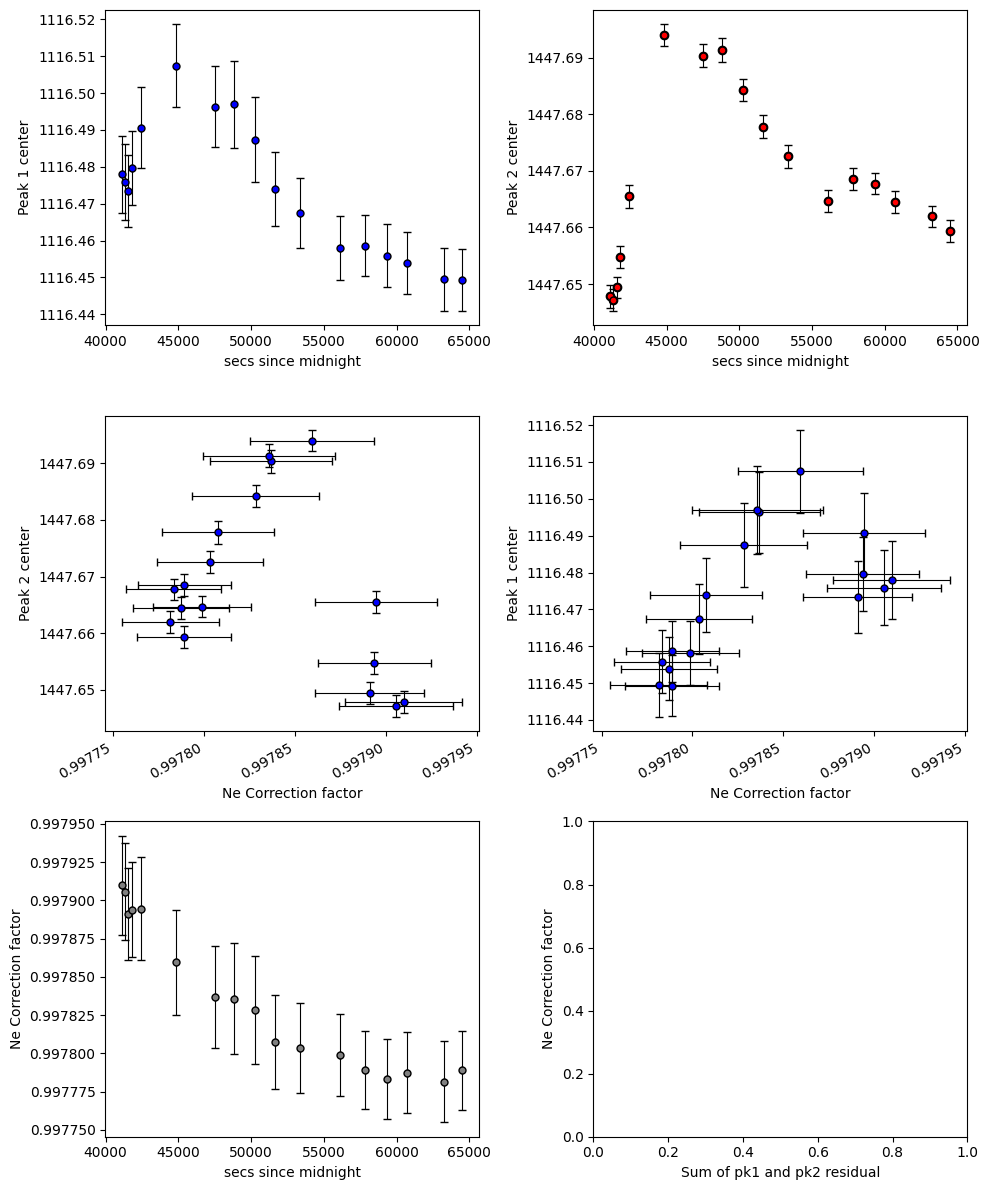

In [22]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [23]:
103.2*0.9979

102.98328000000001

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

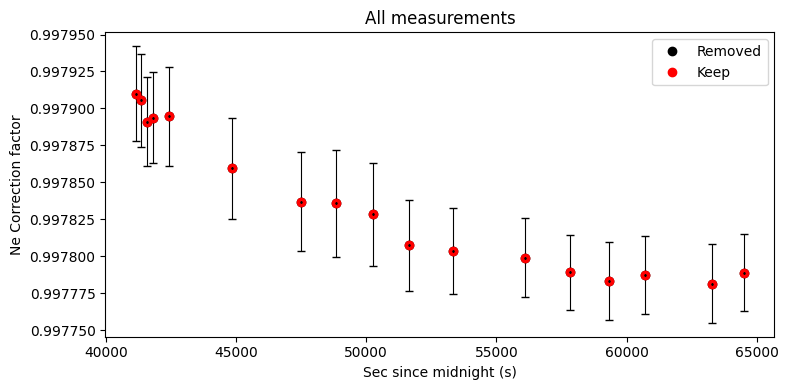

In [24]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

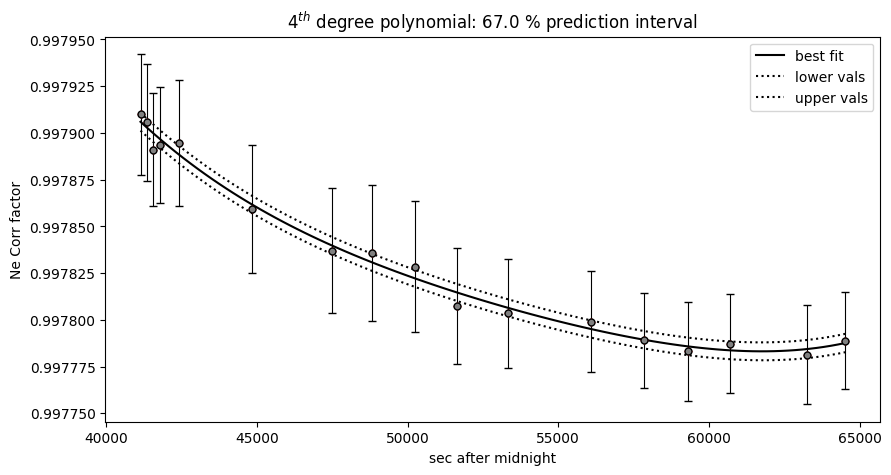

In [25]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=4, CI=0.67, pkl_name='Neon_corr_model.pkl')


In [26]:
import os

if os.name=="posix":

    def mac_notification(title, subtitle, message):
        """
        Display a macOS notification with the default sound using AppleScript.
        
        Args:
        - title: Title of the notification.
        - subtitle: Subtitle of the notification.
        - message: Main message content of the notification.
        """
        os.system("""
                osascript -e 'display notification "{}" with title "{}" subtitle "{}" sound name "default"'
                """.format(message, title, subtitle))

    mac_notification("Notebook Completed", "VSCode", "Step1 Ne lines")

else:

    # %pip install winotify

    from winotify import Notification, audio

    toast= Notification(app_id="VSCode",title="Notebook completed",
                        msg="Step1 Ne lines is done!",
                        duration="short")
    toast.set_audio(audio.Mail,loop=False)
    toast.show()